# Prediksi Kolesterol Tinggi Menggunakan Algoritma Logistic Regression - Tim Invariant

In [37]:
# Import library penting

# Untuk manipulasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import statsmodels.api as sm
from scipy.stats import probplot, skew, kurtosis
from geopy.geocoders import Nominatim
from folium import Map
from folium.plugins import HeatMap
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import geodesic
from math import radians
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Untuk machine learning
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import chi2
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report

# Untuk formatting plot
plt.rc('axes', axisbelow = True)

In [38]:
# Beberapa helper functions berguna yang dibuat oleh tim kami

# Fungsi untuk melakukan outlier detection dengan tukey method
def tukey_method(x):
  col = "Visceral Fat"
  q1 = np.percentile(df[col], 25)
  q3 = np.percentile(df[col], 75)
  iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25)
  batas_bawah = q1 - iqr
  batas_atas = q3 + iqr
  if ((x > batas_atas) or (x < batas_bawah)):
    x = 1
  else:
    x = 0
  return x

# Fungsi untuk mendapatkan skewness dan kurtosis
def get_skewness_kurtosis(df, x):
  print("==============================")
  print(i)

  skewnesss = skew(df[x])
  kurtosiss = kurtosis(df[x])

  print("Skewness: ", skewnesss)
  print("Kurtosis: ", kurtosiss)

  # Cek arti skewness
  if skewnesss > 0:
    print("Distribution is Right Skewed")
  elif skewnesss < 0:
    print("Distribution is Left Skewed")
  else:
    print("Distribution is Symmetric")

  # Cek arti kurtosis
  if kurtosiss > 3:
    print("Distribution is Leptokurtic")
  elif kurtosiss < 3:
    print("Distribution is Platykurtic")
  else:
    print("Distribution is Mesokurtic")

  print("==============================")

  return skewnesss, kurtosiss

# Fungsi untuk melakukan preprocessing dengan nominal dan ordinal
def preprocessing(df):
  # Membuat copy dari dataframe
  df = df.copy()

  # Melakukan encoding feature Jenis Kelamin (nominal)
  labels = ["M", "F"]
  df["Jenis Kelamin"] = df["Jenis Kelamin"].apply(lambda x: 1 if x == "M" else 0)

  # Melakukan encoding feature Cholesterol Total (nominal)
  labels = ["normal", "tinggi"]
  df["CT"] = df["Cholesterol Total (mg/dL)"].apply(lambda x: 1 if x >= 200 else 0)

  # Melakukan encoding feature Usia (ordinal)
  bins = [18, 36, 51, 65]
  labels = ["young", "middle_aged", "old"]
  labels = [0, 1, 2]
  df["Usia"] = pd.cut(df["Usia"], bins, labels = labels)

  # Melakukan encoding IMT (ordinal)
  bins = [-1, 18.5, 25, 30, 100]
  labels = ["underweight", "normal", "overweight", "obesity"]
  labels = [0, 1, 2, 3]
  df["IMT"] = pd.cut(df["IMT (kg/m2)"], bins, labels = labels)

  # Melakukan encoding Masa Kerja (ordinal)
  bins = [-1, 2, 5, 10, 100]
  labels = ["junior", "assoociate", "mid-level", "senior"]
  labels = [0, 1, 2, 3]
  df["Senioritas"] = pd.cut(df["Masa Kerja"], bins, labels = labels)

  # Melakukan drop feature yang sudah tidak diperlukan
  df.drop(["IMT (kg/m2)", "Masa Kerja", "Cholesterol Total (mg/dL)"], axis = 1, inplace = True)

  # Mengelompokkan daerah pada tempat lahir berdasarkan pulau
  jawa = ["Purworejo", "Bogor", "Bandung", "Jakarta", "Cirebon",
          "Indramayu", "Cimahi", "Ciamis", "Bantul", "Gunungkidul",
          "bandung", "Boyolali", "Brebes", "Bekasi", "Sukabumi",
          "Magetan", "Pekalongan", "Sumedang", "Semarang", "Surabaya",
          "Surakarta", "Serang", "Tangerang", "Temanggung", "lamongan",
          "Klaten", "Kebumen", "Purbalingga", "Magelang", "Pemalang",
          "Banyumas", "Tegal", "Salatiga", "Cianjur", "Kediri", "Kulon Progo",
          "Yogyakarta", "Sragen", "GunungKidul", "Majalengka", "Bumi Ayu", "Ngawi",
          "Tasikmalaya", "Lumajang", "Malang", "Ponorogo", "Grobogan", "Cilacap",
          "Solo", "Kendal", "Depok", "Garut", "Jember", "bogor", "Kota Administrasi Jakarta Pusat",
          "Tanah Itam Ulu", "Bondowoso", "Denpasar", "Banjarnegara", "Trenggalek", "Pati", "Tulung Agung",
          "Sleman", "Madiun", "Kota Administrasi Jakarta Barat", "Mataram", "Kuningan", "Tanggerang",
          "Purwakarta", "Jepara", "Sukoharjo", "Lamongan", "Kab. Semarang", "Quelicai", "Sidoarjo",
          "Kota Administrasi Jakarta Selatan", "Srimulyo", "Blora", "Gunung Kidul",
          "Wonogiri", "Wonosobo", "kebumen", "Nganjuk", "Jakarta Utara", "Pandeglang",
          "Banten", "Pamekasan", "Gresik", "Karawang", "Bojonegoro", "Dili",
          "Kota Administrasi Jakarta Utara", "Cibadak", "Kudus", "Pasuruan", "Subang", "Karanganyar"]

  sumatera = ["Teluk Betung", "B. Lampung", "Padang Panjang", "Medan",
              "Pekanbaru", "Manado", "Lampung", "Bukittinggi", "Palembang",
              "Bumi Dipasena", "Kabanjahe", "Tanjung Pandan", "Rengas Pulau",
              "Tanjung Gading", "Bengkulu", "Jambi", "Bukit Tinggi", "Pematangsiantar",
              "Bandar Lampung", "Paya Pasir", "Metro", "Padang", "Soposurung", "Batam",
              "Tanjung Pinang", "Sibolga", "Banda Aceh", "Liwa", "Sungai Penuh", "Negara Jaya",
              "Pekan Baru", "Penago II", "Bonjol", "Lhokseumawe", "Tanjung Agung", "pekanbaru",
              "Tanjung Karang", "Kalidadi", "Lampung Selatan", "Nias", "Pangkalan Brandan",
              "Ujung Batu", "Kota Agung", "Mentok", "Tri Rahayu", "Seirampah", "PEMATANGSIANTAR",
              "Cupak", "Tanjungpinang"]

  kalimantan = ["Samarinda", "Balipapan", "Pontianak", "Pemangkat",
                "Ujung Baru", "Banjarmasin", "Balikpapan", "Singkawang", "Sosok", "Barabai"]

  sulawesi = ["Ambon", "Tana Toraja", "Ujung Padang", "Sungguminasa", "Makassar",
              "Maros", "Ujung Pandang", "Watampone", "Balang Toa", "Raha",
              "Toli - Toli", "Sentani", "Jayapura", "Manokwari"]

  papua = ["Sentani", "Jayapura", "Manokwari"]

  # Melakukan dummy encoding berdasarkan tempat lahir
  df["Sumatera"] = df["Tempat lahir"].isin(sumatera).apply(lambda x: 1 if x == True else 0)
  df["Kalimantan"] = df["Tempat lahir"].isin(kalimantan).apply(lambda x: 1 if x == True else 0)
  df["Sulawesi"] = df["Tempat lahir"].isin(sulawesi).apply(lambda x: 1 if x == True else 0)

  return df

# Fungsi untuk melakukan feature engineering
def feature_engineering(df):
  # Membuat copy dataframe
  df = df.copy()

  # Memperbaiki beberapa inkonsistensi data tempat lahir
  df["Tempat lahir"] = df["Tempat lahir"].str.replace("B. Lampung", "Bandar Lampung")
  df["Tempat lahir"] = df["Tempat lahir"].str.replace("Balipapan", "Balikpapan")
  df["Tempat lahir"] = df["Tempat lahir"].str.replace("Kab. Semarang", "Semarang")
  df["Tempat lahir"] = df["Tempat lahir"].str.replace("Kalidadi", "Kali Dadi")
  df["Tempat lahir"] = df["Tempat lahir"].str.replace("Seirampah", "Sei Rampah")

  # Mendapatkan lintang dan bujur tempat lahir
  lintang_s = []
  bujur_s = []
  geolocator = Nominatim(user_agent = "MyAppCool")
  for i in df["Tempat lahir"].unique():
    location = geolocator.geocode(i)
    lintang_s.append(location.latitude)
    bujur_s.append(location.longitude)
  result = pd.DataFrame()
  result["Tempat lahir"] = df["Tempat lahir"].unique()
  result["Lintang"] = lintang_s
  result["Bujur"] = bujur_s

  # Melakukan penggabungan dataframe
  df = pd.merge(df, result, on = "Tempat lahir")

  # Melakukan pengambilan data di Indonesia saja
  df = df[df["Bujur"] > 20].copy().reset_index(drop = True)

  # Membuat feaature dari cartesian ke polar
  df["r"] = np.sqrt(df["Lintang"]**2 + df["Bujur"]**2)
  df["theta"] = np.arctan2(df["Lintang"], df["Bujur"])

  # Membuat feature rotasi 15, 30, 45 derajat
  df['rot_15_x'] = (np.cos(np.radians(15)) * df['Bujur']) + \
                    (np.sin(np.radians(15)) * df['Lintang'])
  df['rot_15_y'] = (np.cos(np.radians(15)) * df['Lintang']) + \
                    (np.sin(np.radians(15)) * df['Bujur'])
  df['rot_30_x'] = (np.cos(np.radians(30)) * df['Bujur']) + \
                    (np.sin(np.radians(30)) * df['Lintang'])
  df['rot_30_y'] = (np.cos(np.radians(30)) * df['Lintang']) + \
                    (np.sin(np.radians(30)) * df['Bujur'])
  df['rot_45_x'] = (np.cos(np.radians(44)) * df['Bujur']) + \
                    (np.sin(np.radians(45)) * df['Lintang'])
  df['rot_45_y'] = (np.cos(np.radians(44)) * df['Lintang']) + \
                    (np.sin(np.radians(45)) * df['Bujur'])

  # Melakukan encoding tempat lahir
  df["Tempat lahir"] = df["Sumatera"].astype("string") + df["Kalimantan"].astype("string") + df["Sulawesi"].astype("string")

  # Melakukan ordinal encoding tempat lahir 0:Jawa, 1:Sulawesi, 2:Kalimantan, 3:Sumatera
  encoder = OrdinalEncoder()
  encoded = pd.DataFrame(encoder.fit_transform(df[["Tempat lahir"]]), columns = ["Tempat lahir"])
  df = pd.concat([df.drop("Tempat lahir", axis = 1), encoded], axis = 1)

  return df

# Fungsi untuk menghitung Variance Inflation Factor (VIF)
def calc_vif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return(vif)

# Fungsi untuk menghitung AIC dan BIC atau uji kecocokan model
def calc_aic_bic(X, y, cols):
  k_s = []
  log_likelihood = []
  AIC_s = []
  BIC_s = []
  n = X.shape[0]

  for i, col in enumerate(cols):
    # Mendapatkan jumlah parameter k
    dummy = X[col].copy()
    k = dummy.shape[1] + 1
    k_s.append(k)

    # Mendapatkan log-likelihood
    dummy = sm.add_constant(dummy)
    X_train, X_valid, y_train, y_valid = train_test_split(dummy, y, test_size = 0.20, random_state = 27)
    model = sm.Logit(y_train, X_train).fit()
    log_likelihood.append(model.llf)

    # Menghitung AIC
    AIC = 2*k - 2*(model.llf)
    AIC_s.append(AIC)

    # Menghitung BIC
    BIC = k*np.log(n) - 2*(model.llf)
    BIC_s.append(BIC)

  # Membuat dataframe rangkuman hasil
  result = pd.DataFrame()
  result["Variabel"] = cols
  result["Jumlah Parameter"] = k_s
  result["Log-Likelihood"] = log_likelihood
  result["AIC"] = AIC_s
  result["BIC"] = BIC_s

  return result

# Fungsi untuk melakukan uji performa model
def uji_performa_model(X, y, random_state):
  # Mengambil dan membuat copy X
  X = X.copy()

  # Melakukan train test split
  X = sm.add_constant(X)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = random_state)

  # Melakukan logistic regression dengan statsmodels
  model = sm.Logit(y_train, X_train).fit()

  # Melakukan prediksi X_valid
  preds = np.round(model.predict(X_valid))

  return model, classification_report(preds, y_valid)

# Fungsi untuk melakukan uji performa model dengan cross validation
def cross_validation(models):
  means = []
  stds = []
  for i in models:
    model = i
    scores = cross_val_score(model, X, y, cv = 10, scoring = "accuracy")
    means.append(scores.mean())
    stds.append(scores.std())
  dummy = pd.DataFrame({"Model":models, "Mean":means, "Std":stds})
  return dummy

# Data Cleaning

In [3]:
# Membaca data dari direktori
df = pd.read_csv("/content/Data Kesehatan Karyawan-Data 1 & Data 2.csv", sep = ";")
df = df.iloc[0:1339, 0:16]

# Drop kolom responden
df.drop("Responden", axis = 1, inplace = True)

In [4]:
# Melihat dataframe
df

Jenis Kelamin  Usia  Tekanan darah  (S)  Tekanan darah  (D)  \
0                M  19.0               126.0                88.0   
1                M  19.0               120.0                80.0   
2                M  19.0               120.0                80.0   
3                F  19.0               100.0                70.0   
4                M  19.0               110.0                70.0   
...            ...   ...                 ...                 ...   
1334             M  39.0               110.0                70.0   
1335             F  39.0               120.0                70.0   
1336             F  39.0               120.0                80.0   
1337             M  39.0               110.0                70.0   
1338             F  39.0               110.0                70.0   

      Tinggi badan (cm)  Berat badan (kg)  IMT (kg/m2)  Lingkar perut (cm)  \
0                 172.5             49.50        16.53                66.0   
1                 158.0             53.60        21.50                71.0   
2                 170.0             59.50        20.59                80.0   
3                 149.0             45.10        20.31                62.0   
4                 171.6             62.40        21.19                78.0   
...                 ...               ...          ...                 ...   
1334              162.5             67.60        25.60                87.0   
1335              150.0             60.50        26.90                77.0   
1336              151.0             59.75        26.20                78.0   
1337              166.2             57.00        20.63                69.0   
1338              155.0             52.15        21.70                70.0   

      Glukosa Puasa (mg/dL)  Cholesterol Total (mg/dL)  Trigliserida (mg/dL)  \
0                      84.0                      187.0                  99.0   
1                      84.0                      187.0                  99.0   
2                      80.0                      187.0                  99.0   
3                      81.0                      187.0                  99.0   
4                      84.0                      187.0                  99.0   
...                     ...                        ...                   ...   
1334                   84.0                      169.0                  72.0   
1335                   84.0                      199.0                 105.0   
1336                   84.0                      177.0                  78.0   
1337                   84.0                      244.0                  98.0   
1338                   84.0                      180.0                  51.0   

       Fat  Visceral Fat  Masa Kerja  Tempat lahir  
0     26.4           6.0        0.97     Purworejo  
1     26.4           6.0        0.60         Bogor  
2     26.4           6.0        1.37       bandung  
3     30.5           3.5        1.00       Jakarta  
4     26.4           6.0        4.00  Teluk Betung  
...    ...           ...         ...           ...  
1334  23.8          11.0        6.00         Bogor  
1335  38.1           9.0        6.15         Bogor  
1336  35.3           8.0       26.00         Bogor  
1337  17.1           5.0        4.30         Bogor  
1338  26.4           6.0        5.49   Tasikmalaya  

[1339 rows x 15 columns]

In [ ]:
# Melakukan pengecekan tipe data feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Jenis Kelamin              1339 non-null   object 
 1   Usia                       1339 non-null   float64
 2   Tekanan darah  (S)         1339 non-null   float64
 3   Tekanan darah  (D)         1339 non-null   float64
 4   Tinggi badan (cm)          1339 non-null   float64
 5   Berat badan (kg)           1339 non-null   float64
 6   IMT (kg/m2)                1339 non-null   float64
 7   Lingkar perut (cm)         1339 non-null   float64
 8   Glukosa Puasa (mg/dL)      1339 non-null   float64
 9   Cholesterol Total (mg/dL)  1339 non-null   float64
 10  Trigliserida (mg/dL)       1339 non-null   float64
 11  Fat                        1339 non-null   float64
 12  Visceral Fat               1339 non-null   float64
 13  Masa Kerja                 1339 non-null   float

In [ ]:
# Melakukan pengecekan missing values
df.isnull().sum()

Jenis Kelamin                0
Usia                         0
Tekanan darah  (S)           0
Tekanan darah  (D)           0
Tinggi badan (cm)            0
Berat badan (kg)             0
IMT (kg/m2)                  0
Lingkar perut (cm)           0
Glukosa Puasa (mg/dL)        0
Cholesterol Total (mg/dL)    0
Trigliserida (mg/dL)         0
Fat                          0
Visceral Fat                 0
Masa Kerja                   0
Tempat lahir                 0
dtype: int64

In [ ]:
# Melakukan pengecekan baris duplikat
df.duplicated().sum()
df.drop(["Jenis Kelamin", "Tempat lahir"], axis = 1).duplicated().sum()

0

In [ ]:
# Melakukan pengecekan statistika deskriptif
df.describe()

Usia  Tekanan darah  (S)  Tekanan darah  (D)  Tinggi badan (cm)  \
count  1339.000000         1339.000000         1339.000000        1339.000000   
mean     28.597461          113.147872           74.009709         164.940851   
std       4.767230           10.164592            7.718752           7.386617   
min      19.000000           80.000000           58.000000         138.500000   
25%      25.000000          110.000000           70.000000         160.000000   
50%      28.000000          110.000000           72.000000         165.000000   
75%      31.000000          120.000000           80.000000         170.000000   
max      39.000000          170.000000          100.000000         187.500000   

       Berat badan (kg)  IMT (kg/m2)  Lingkar perut (cm)  \
count       1339.000000  1339.000000         1339.000000   
mean          64.620500    23.693727           80.441972   
std           12.799096     4.021585           10.688215   
min           38.500000    14.850000           54.000000   
25%           55.275000    20.855000           72.000000   
50%           62.500000    23.200000           80.000000   
75%           71.775000    26.000000           87.000000   
max          139.750000    44.100000          128.000000   

       Glukosa Puasa (mg/dL)  Cholesterol Total (mg/dL)  Trigliserida (mg/dL)  \
count            1339.000000                1339.000000           1339.000000   
mean               84.571322                 187.995519            106.982823   
std                11.522057                  21.104834             44.143456   
min                65.000000                 103.000000             34.000000   
25%                84.000000                 187.000000             99.000000   
50%                84.000000                 187.000000             99.000000   
75%                84.000000                 187.000000             99.000000   
max               321.000000                 308.000000            634.000000   

               Fat  Visceral Fat   Masa Kerja  
count  1339.000000   1339.000000  1339.000000  
mean     26.203510      6.231367     6.401837  
std       3.678467      2.431923     4.554438  
min       5.800000      0.500000     0.000000  
25%      26.400000      6.000000     4.000000  
50%      26.400000      6.000000     6.000000  
75%      26.400000      6.000000     8.000000  
max      40.900000     23.000000    31.000000

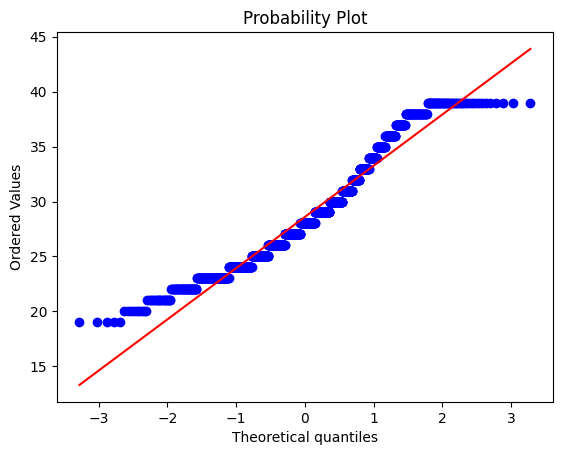

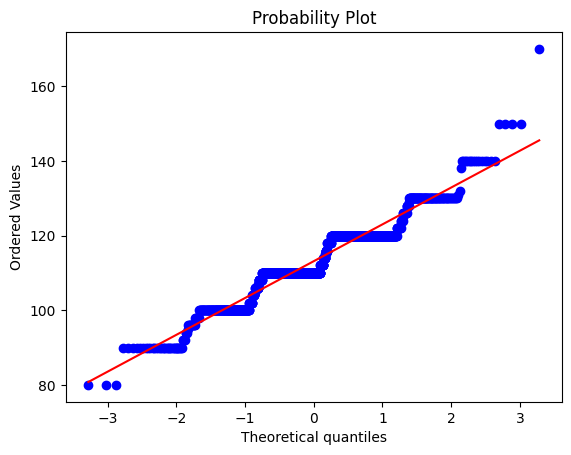

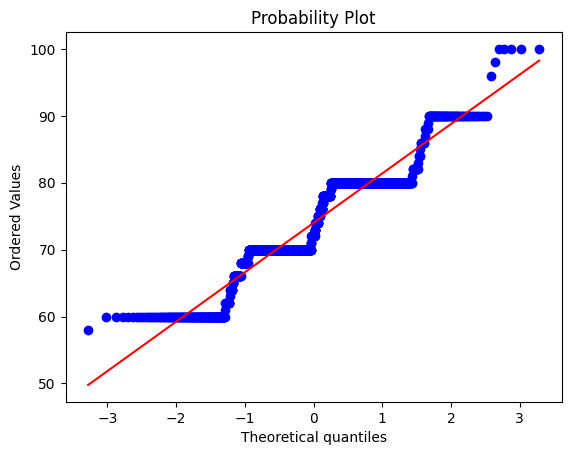

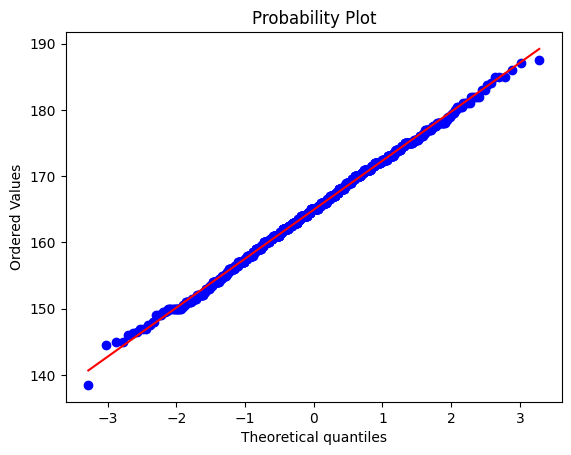

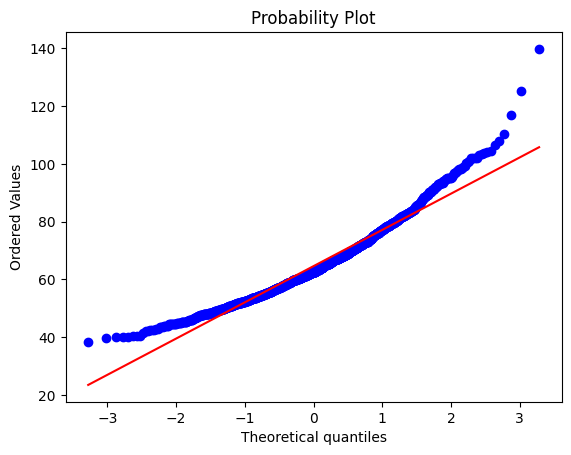

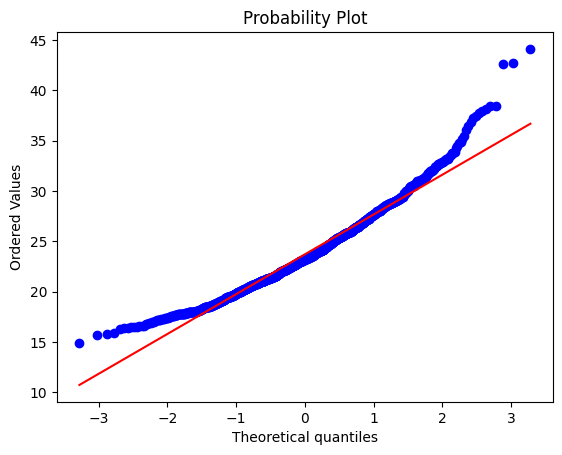

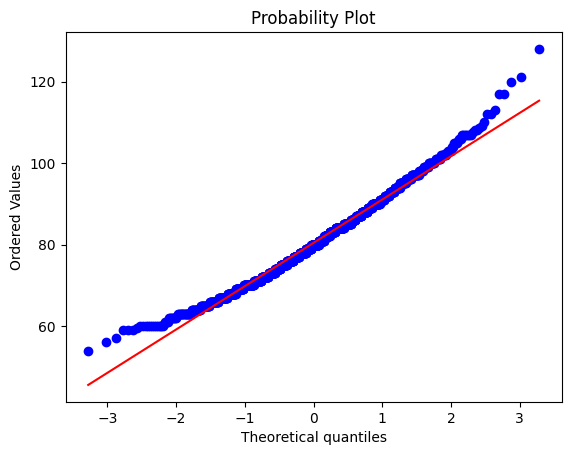

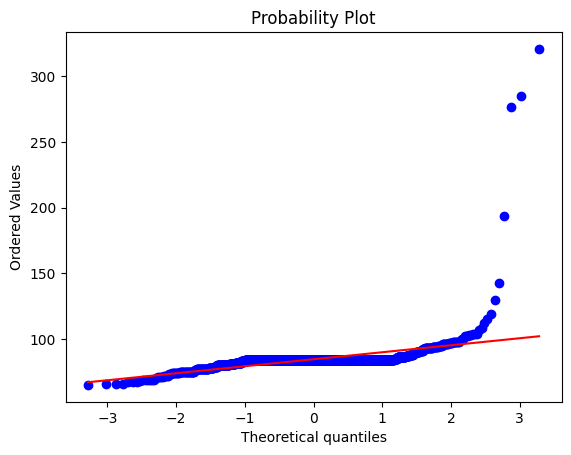

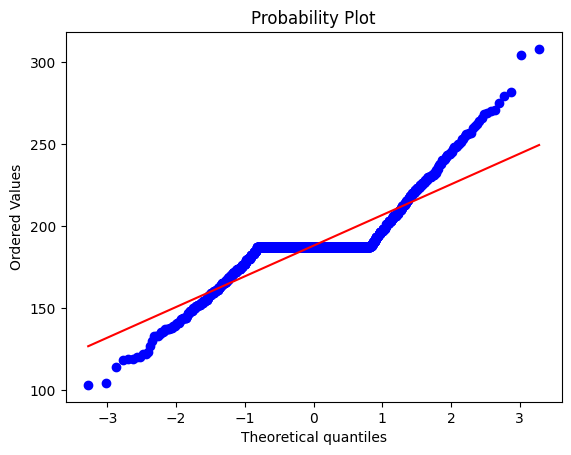

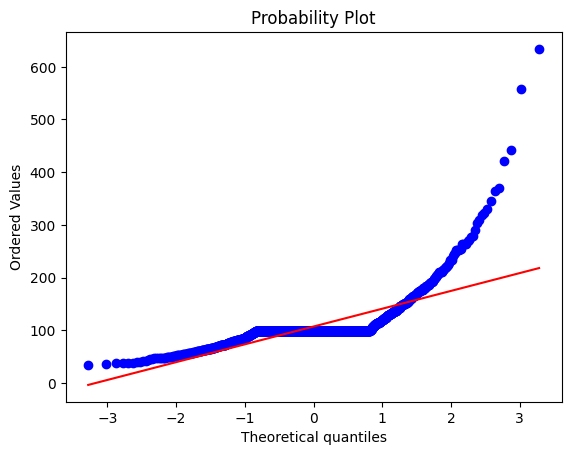

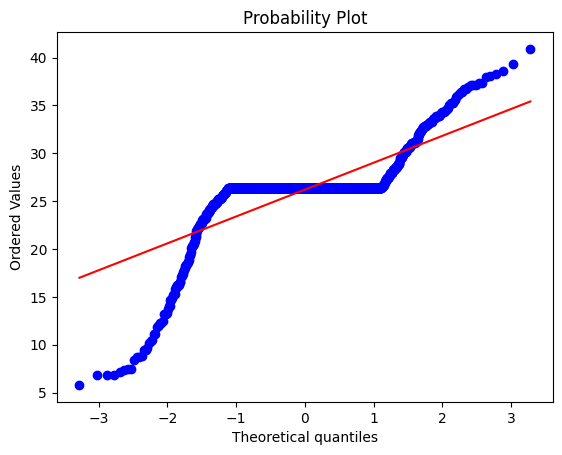

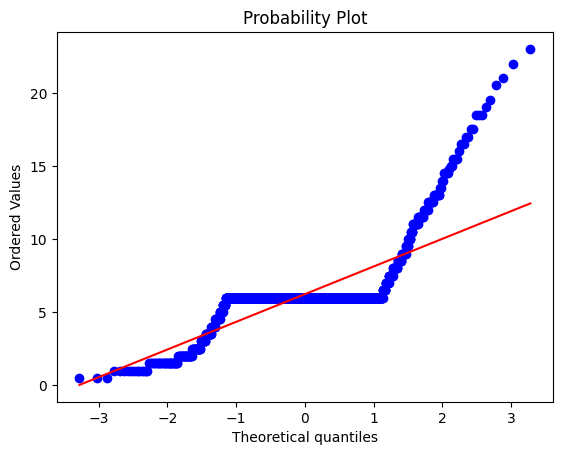

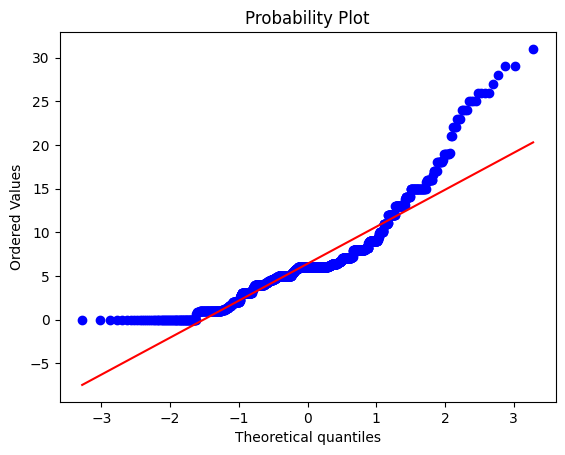

In [ ]:
# Melakukan visualisasi QQ plot untuk pengecekan normalitas feature numerik
# Hampir semua tidak mengikuti distribusi normal, artinya harus menggunakan non-parametric test
numeric = ['Usia', 'Tekanan darah  (S)', 'Tekanan darah  (D)',
       'Tinggi badan (cm)', 'Berat badan (kg)', 'IMT (kg/m2)',
       'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)',
       'Cholesterol Total (mg/dL)', 'Trigliserida (mg/dL)', 'Fat',
       'Visceral Fat', 'Masa Kerja']
for i in numeric:
  fig, ax = plt.subplots(1)
  probplot(df[i], dist = "norm", plot = pylab)

In [ ]:
# Melakukan pengecekan kurtosis serta skewness masing-masing feature
for i in numeric:
  skewnesss, kurtosiss = get_skewness_kurtosis(df, i)

Usia
Skewness:  0.5624924050109597
Kurtosis:  -0.48791254431849573
Distribution is Right Skewed
Distribution is Platykurtic
Tekanan darah  (S)
Skewness:  0.15462803958508134
Kurtosis:  0.9933207811628617
Distribution is Right Skewed
Distribution is Platykurtic
Tekanan darah  (D)
Skewness:  0.05545762119142326
Kurtosis:  -0.14361768440629863
Distribution is Right Skewed
Distribution is Platykurtic
Tinggi badan (cm)
Skewness:  -0.058273808502390854
Kurtosis:  -0.13380066348269404
Distribution is Left Skewed
Distribution is Platykurtic
Berat badan (kg)
Skewness:  0.9269833459858352
Kurtosis:  1.5166873343867486
Distribution is Right Skewed
Distribution is Platykurtic
IMT (kg/m2)
Skewness:  0.8354782980618995
Kurtosis:  1.3432126441083536
Distribution is Right Skewed
Distribution is Platykurtic
Lingkar perut (cm)
Skewness:  0.471902065480605
Kurtosis:  0.231147884537926
Distribution is Right Skewed
Distribution is Platykurtic
Glukosa Puasa (mg/dL)
Skewness:  14.707050339431893
Kurtosis:  2

In [5]:
# Melakukan preprocessing dataframe
df = preprocessing(df)

In [6]:
# Melakukan feature engineering
df = feature_engineering(df)

In [7]:
# Melihat dataframe hasil preprocessing dan feature engineering
df.iloc[:, 17:-1]

Lintang       Bujur           r     theta    rot_15_x   rot_15_y  \
0    -7.707302  109.966512  110.236274 -0.069973  104.224697  21.016745   
1    -7.707302  109.966512  110.236274 -0.069973  104.224697  21.016745   
2    -7.707302  109.966512  110.236274 -0.069973  104.224697  21.016745   
3    -7.707302  109.966512  110.236274 -0.069973  104.224697  21.016745   
4    -7.707302  109.966512  110.236274 -0.069973  104.224697  21.016745   
...        ...         ...         ...       ...         ...        ...   
1328  3.484872   99.137631   99.198862  0.035137   96.661549  29.024834   
1329  3.001910   99.083314   99.128778  0.030288   96.484084  28.544271   
1330 -2.585530  115.384523  115.413487 -0.022404  110.783706  27.366282   
1331 -8.033597  113.266224  113.550765 -0.070808  107.327523  21.555597   
1332 -7.388571  112.291649  112.534463 -0.065703  106.553101  21.926406   

       rot_30_x   rot_30_y   rot_45_x   rot_45_y  
0     91.380142  48.308536  73.653403  72.213897  
1     91.380142  48.308536  73.653403  72.213897  
2     91.380142  48.308536  73.653403  72.213897  
3     91.380142  48.308536  73.653403  72.213897  
4     91.380142  48.308536  73.653403  72.213897  
...         ...        ...        ...        ...  
1328  87.598143  52.586803  73.777820  72.607698  
1329  87.309622  52.141387  73.397242  72.221877  
1330  98.633163  55.453127  81.172434  79.729304  
1331  94.074629  49.675813  75.796292  74.312429  
1332  93.553135  49.747134  75.551344  74.087293  

[1333 rows x 10 columns]

# Exploratory Data Analysis

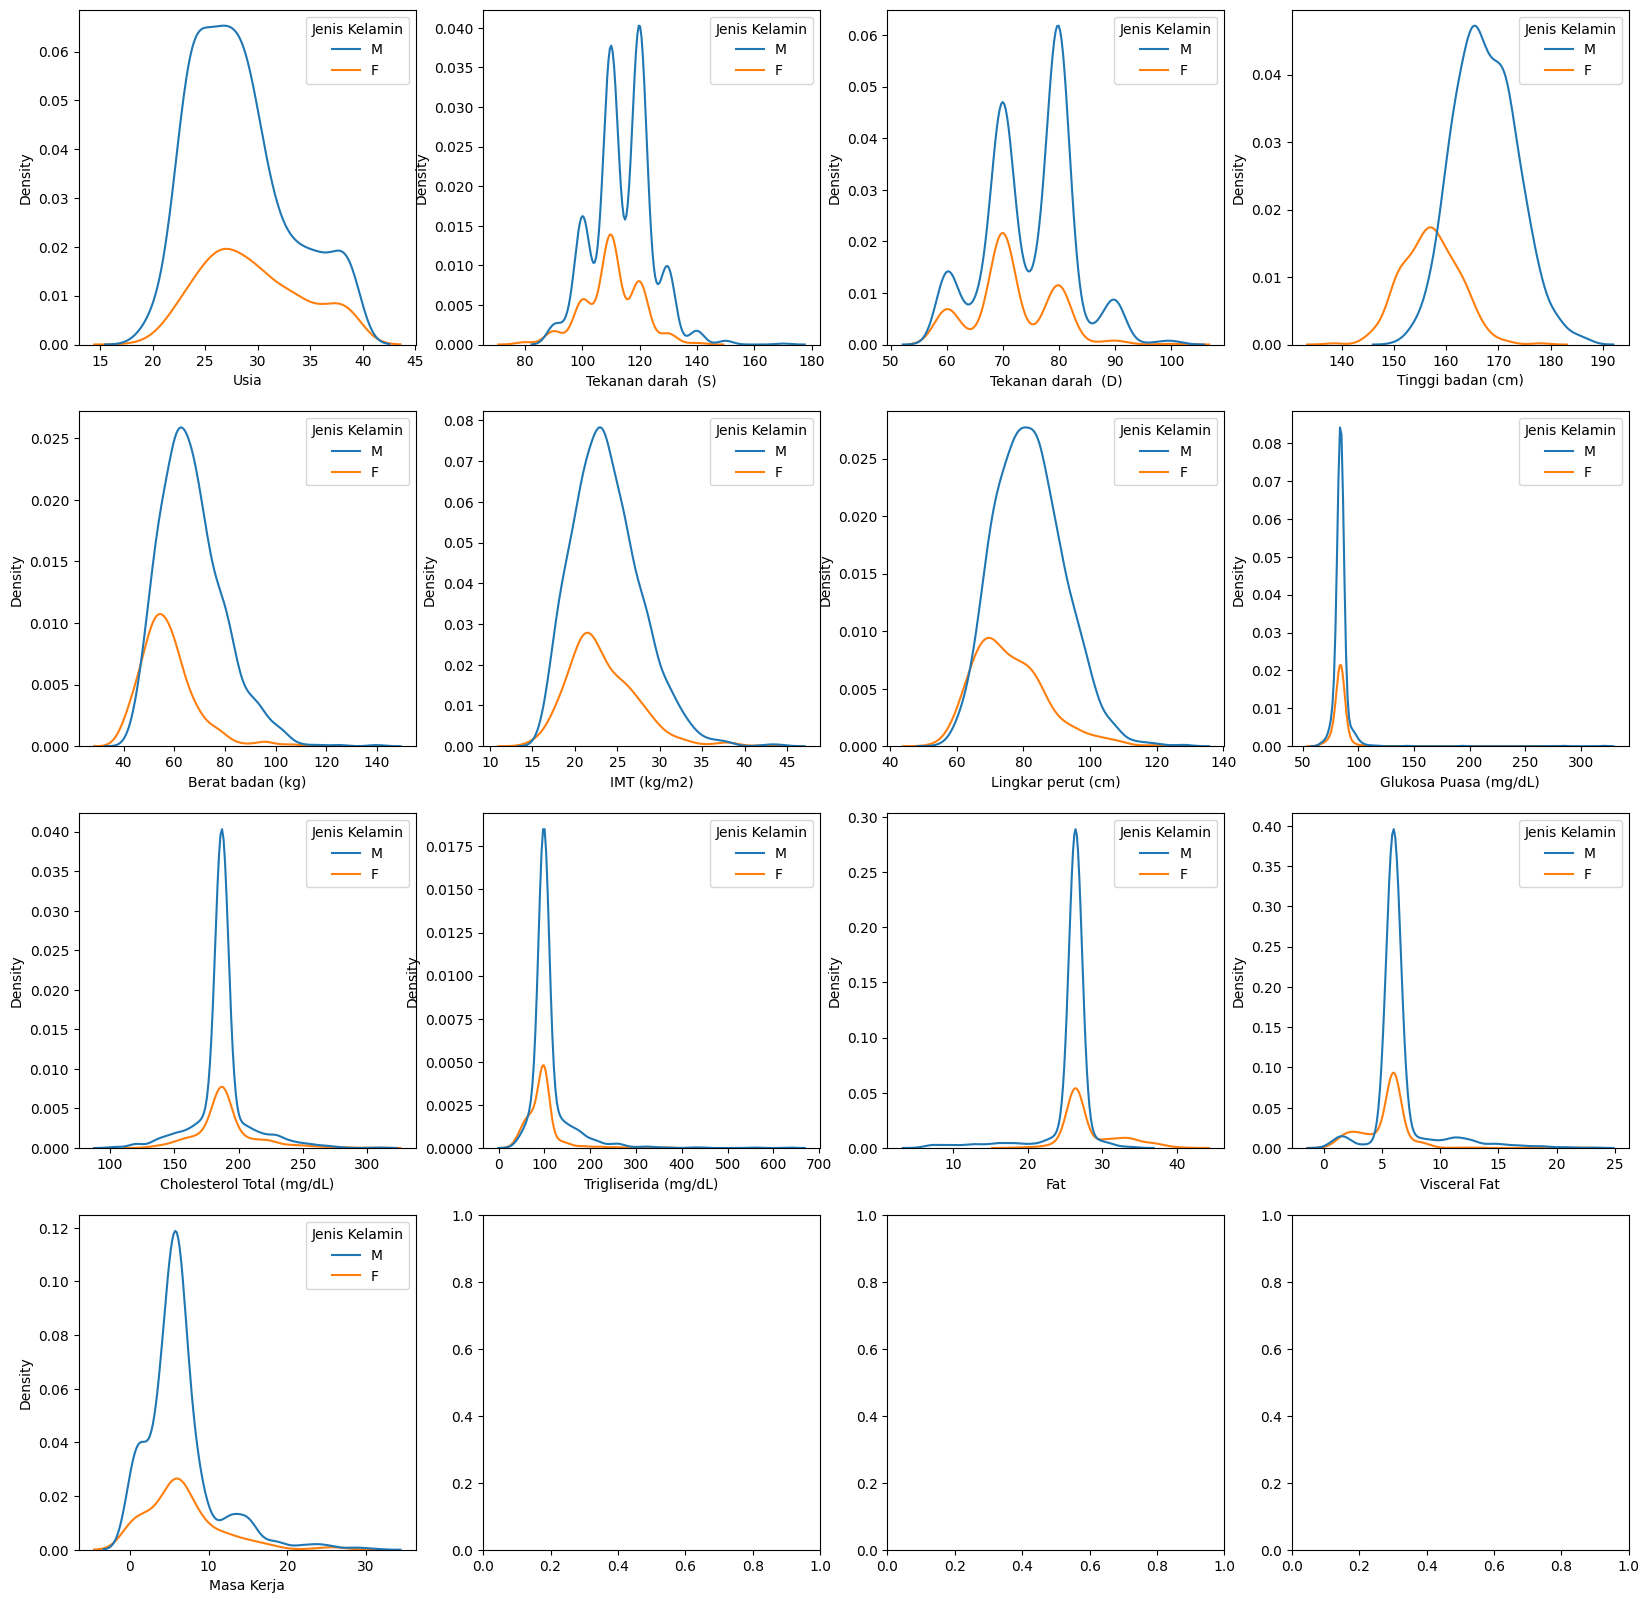

In [ ]:
# Melakukan visualisasi feature numerik
numeric = ['Usia', 'Tekanan darah  (S)', 'Tekanan darah  (D)',
       'Tinggi badan (cm)', 'Berat badan (kg)', 'IMT (kg/m2)',
       'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)',
       'Cholesterol Total (mg/dL)', 'Trigliserida (mg/dL)', 'Fat',
       'Visceral Fat', 'Masa Kerja']

fig, ax = plt.subplots(4, 4, figsize = (20, 20))
ax = ax.flatten()

for i, j in enumerate(numeric):
  sns.kdeplot(x = j, hue = "Jenis Kelamin", data = df, ax = ax[i])

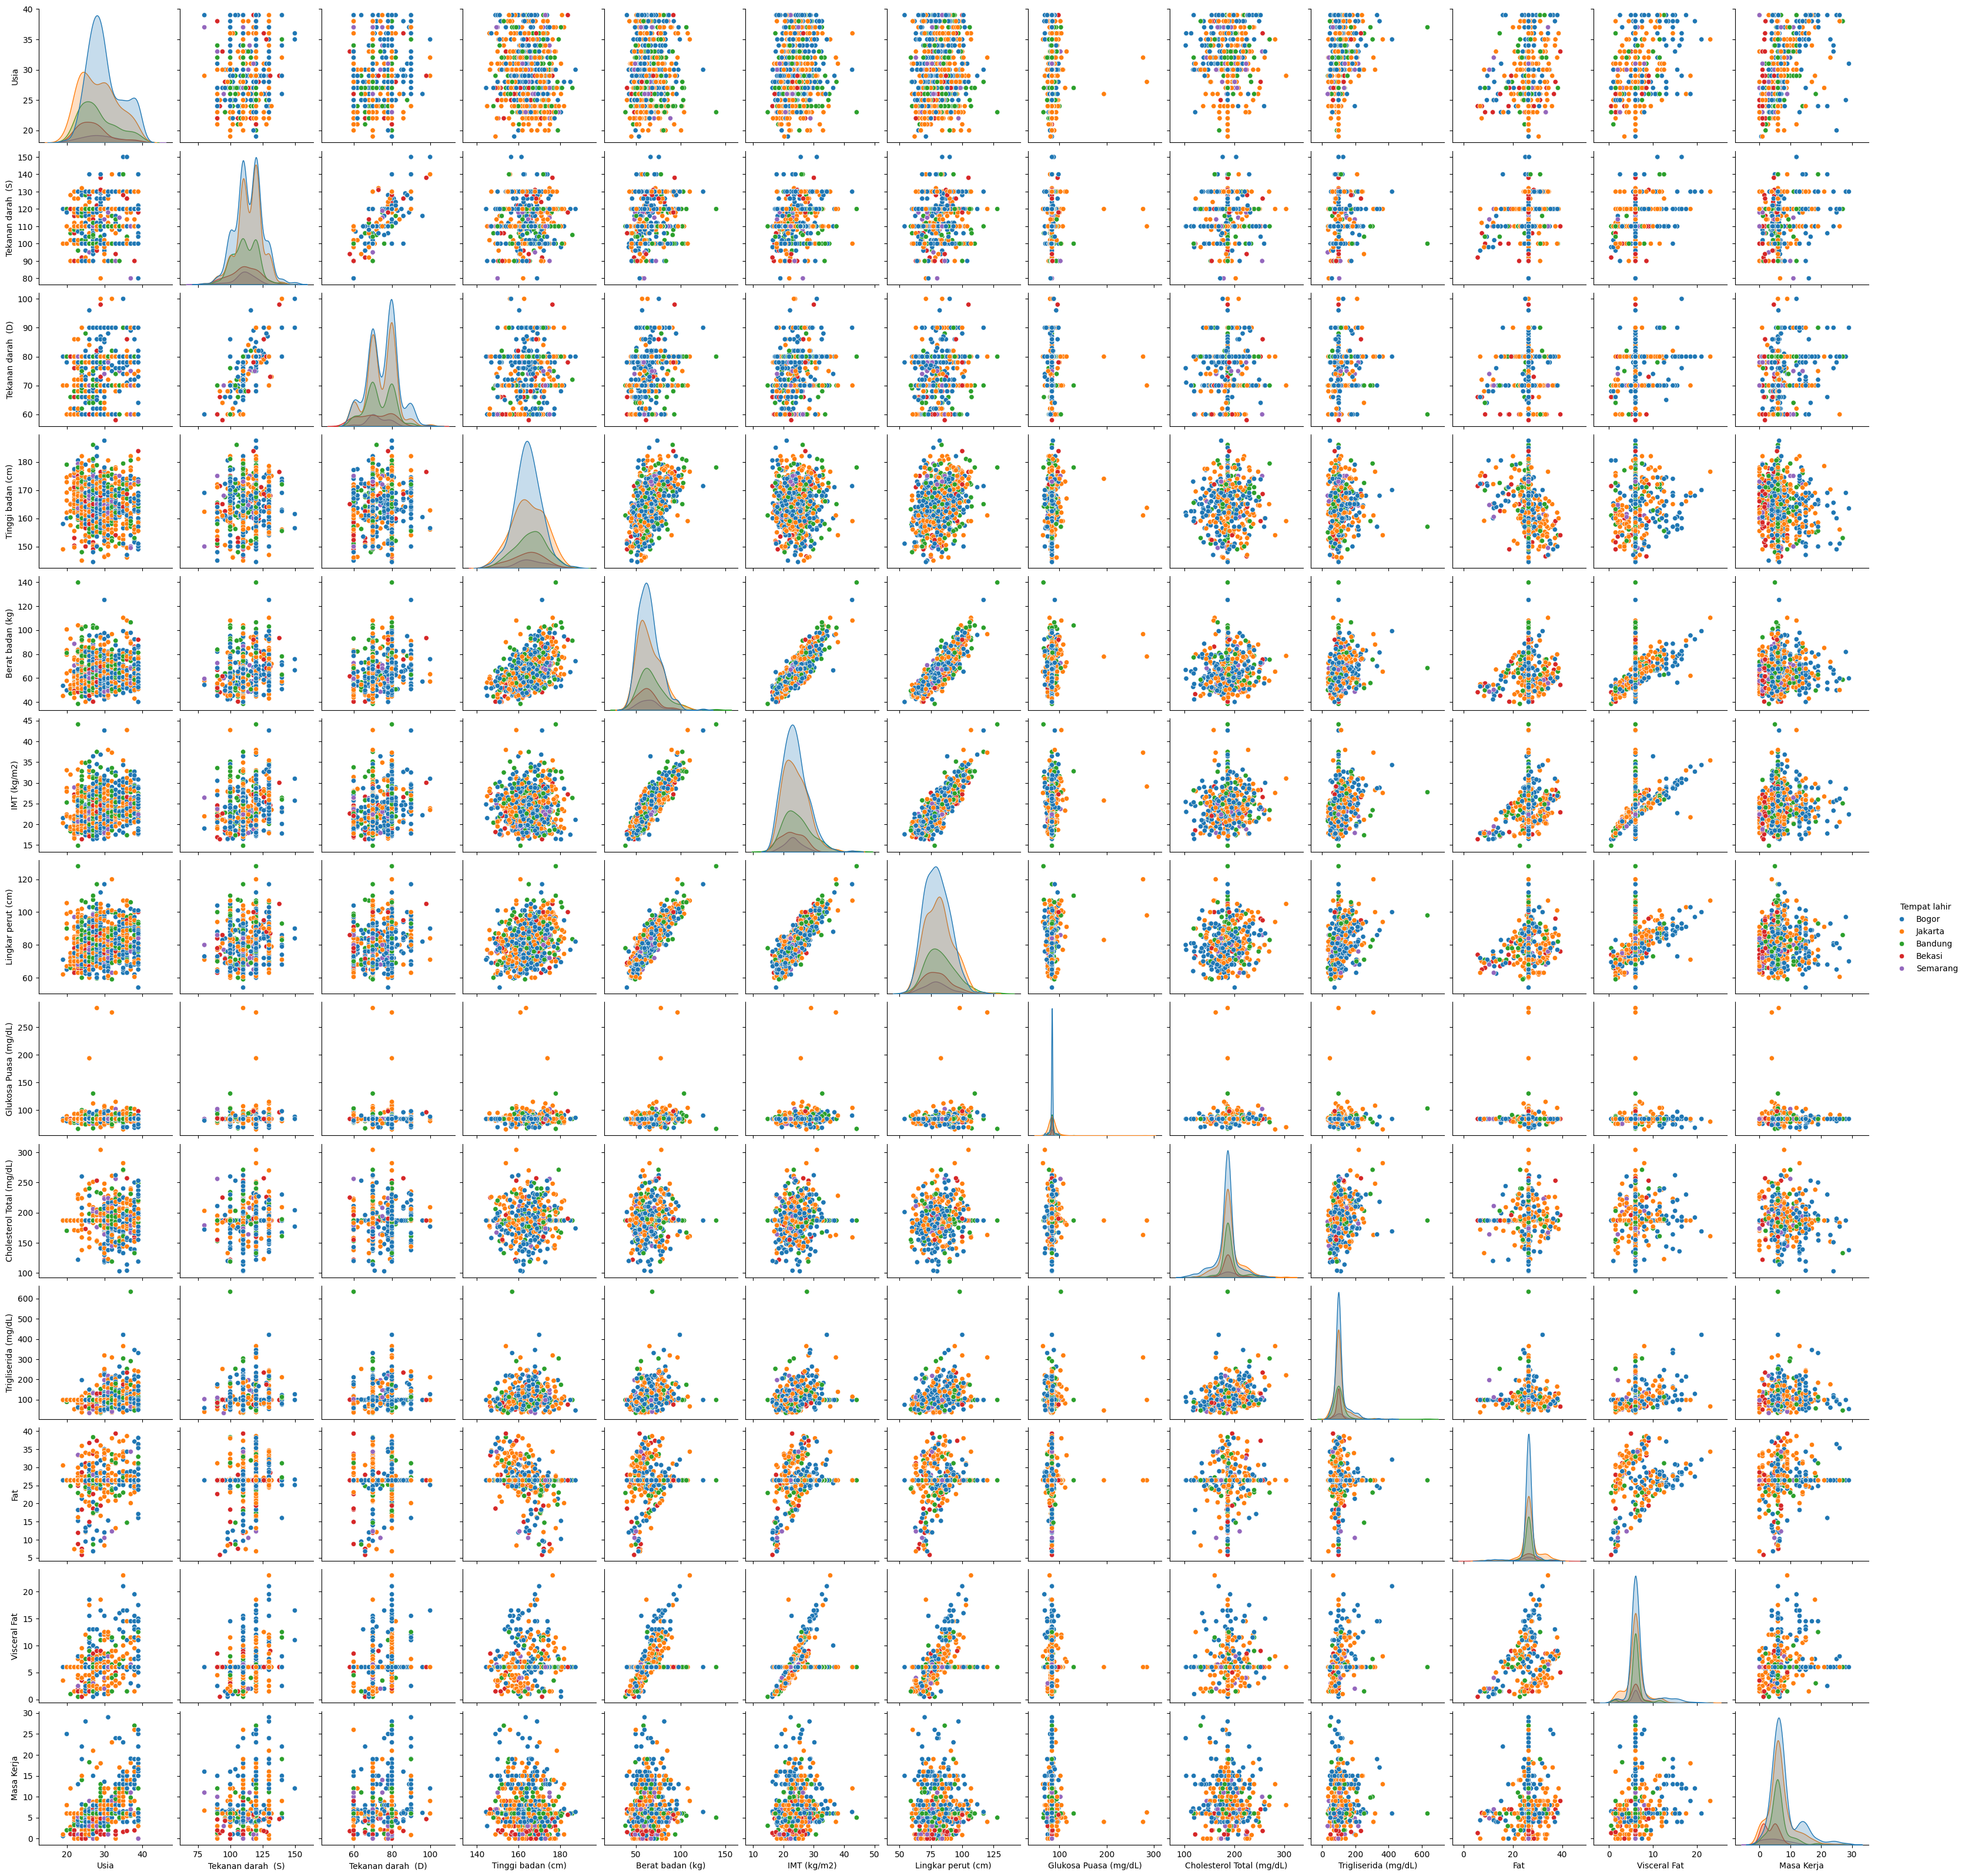

In [ ]:
sns.pairplot(temp.drop("Jenis Kelamin", axis = 1), hue = "Tempat lahir")

In [ ]:
# Melakukan visualisasi heatmap
heat_data = [[row['Lintang'], row['Bujur']] for _, row in df.iterrows()]
heat_map = Map(df[['Lintang', 'Bujur']].mean(axis=0), zoom_start = 6)
HeatMap(heat_data, radius=10).add_to(heat_map)
heat_map

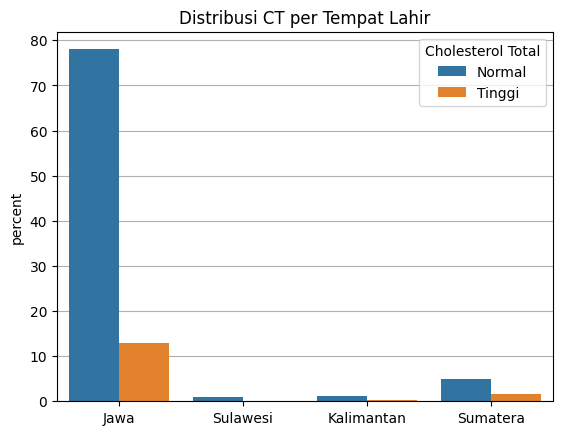

In [ ]:
# Visualisasi distribusi CT per Temoat Lahir
sns.countplot(df, x = "Tempat lahir", hue = "CT", stat = "percent")
plt.title("Distribusi CT per Tempat Lahir")
plt.xlabel("")
plt.legend(["Normal", "Tinggi"], title = "Cholesterol Total")
plt.xticks([0, 1, 2, 3], ["Jawa", "Sulawesi", "Kalimantan", "Sumatera"])
plt.grid(visible = True, axis = "y")
plt.show()

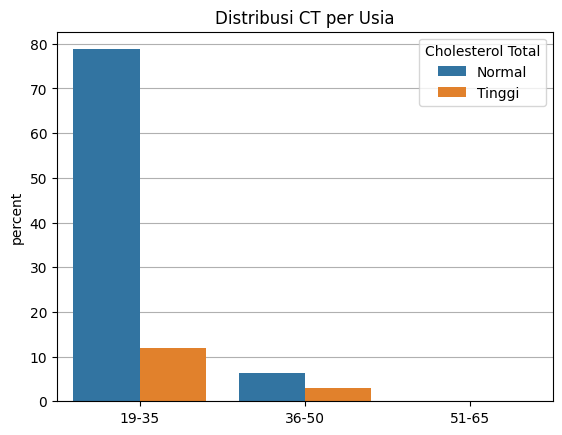

In [ ]:
# Visualisasi distribusi CT per Usia
sns.countplot(df, x = "Usia", hue = "CT", stat = "percent")
plt.title("Distribusi CT per Usia")
plt.xlabel("")
plt.legend(["Normal", "Tinggi"], title = "Cholesterol Total")
plt.xticks([0, 1, 2], ["19-35", "36-50", "51-65"])
plt.grid(visible = True, axis = "y")
plt.show()

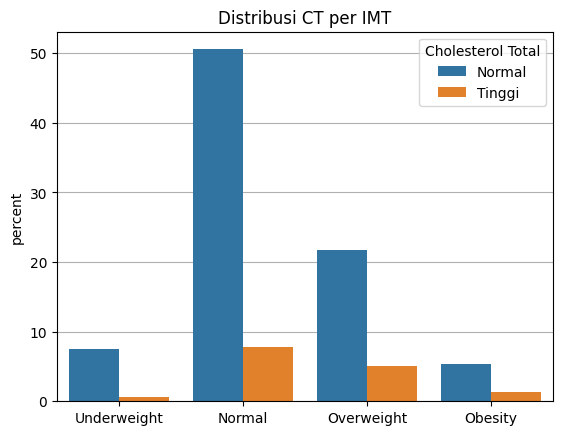

In [ ]:
# Visualisasi distribusi CT per IMT
sns.countplot(df, x = "IMT", hue = "CT", stat = "percent")
plt.title("Distribusi CT per IMT")
plt.xlabel("")
plt.legend(["Normal", "Tinggi"], title = "Cholesterol Total")
plt.xticks([0, 1, 2, 3], ["Underweight", "Normal", "Overweight", "Obesity"])
plt.grid(visible = True, axis = "y")
plt.show()

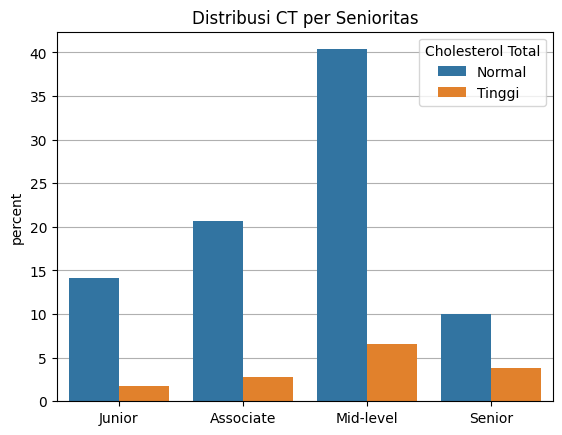

In [ ]:
# Visualisasi distribusi CT per Senioritas
sns.countplot(df, x = "Senioritas", hue = "CT", stat = "percent")
plt.title("Distribusi CT per Senioritas")
plt.xlabel("")
plt.legend(["Normal", "Tinggi"], title = "Cholesterol Total")
plt.xticks([0, 1, 2, 3], ["Junior", "Associate", "Mid-level", "Senior"])
plt.grid(visible = True, axis = "y")
plt.show()

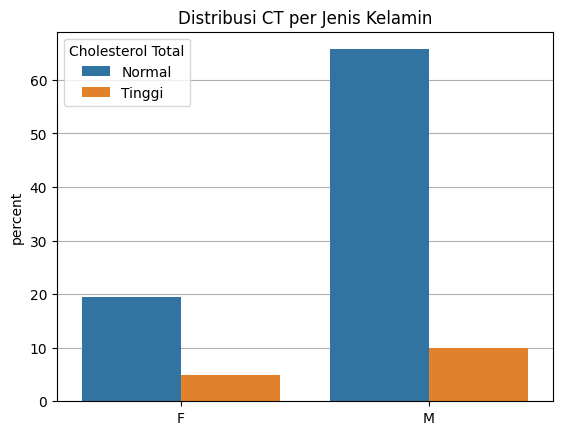

In [ ]:
# Visualisasi distribusi CT per Jenis Kelamin
sns.countplot(df, x = "Jenis Kelamin", hue = "CT", stat = "percent")
plt.title("Distribusi CT per Jenis Kelamin")
plt.xlabel("")
plt.legend(["Normal", "Tinggi"], title = "Cholesterol Total")
plt.xticks([0, 1], ["F", "M"])
plt.grid(visible = True, axis = "y")
plt.show()

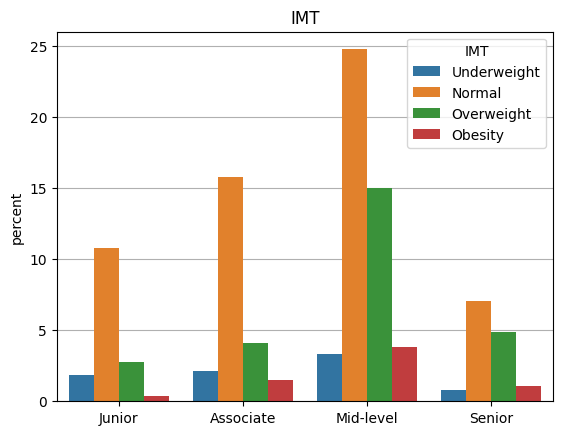

In [ ]:
# Visualisasi hubungan Senioritas terhadap IMT
sns.countplot(df, x = "Senioritas", hue = "IMT", stat = "percent")
plt.title("IMT")
plt.xlabel("")
plt.legend(["Underweight", "Normal", "Overweight", "Obesity"], title = "IMT")
plt.xticks([0, 1, 2, 3], ["Junior", "Associate", "Mid-level", "Senior"])
plt.grid(visible = True, axis = "y")
plt.show()

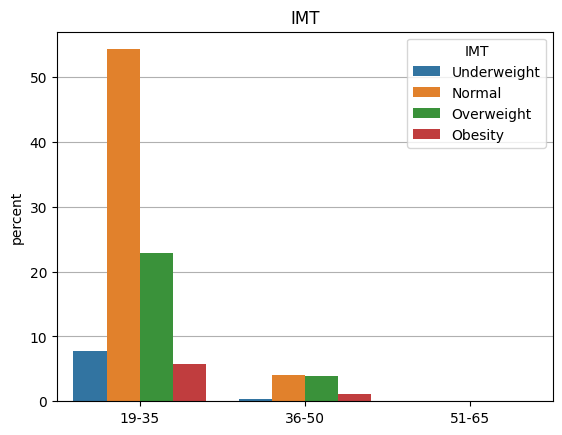

In [ ]:
# Visualisasi hubungan Usia terhadap IMT
sns.countplot(df, x = "Usia", hue = "IMT", stat = "percent")
plt.title("IMT")
plt.xlabel("")
plt.legend(["Underweight", "Normal", "Overweight", "Obesity"], title = "IMT")
plt.xticks([0, 1, 2], ["19-35", "36-50", "51-65"])
plt.grid(visible = True, axis = "y")
plt.show()

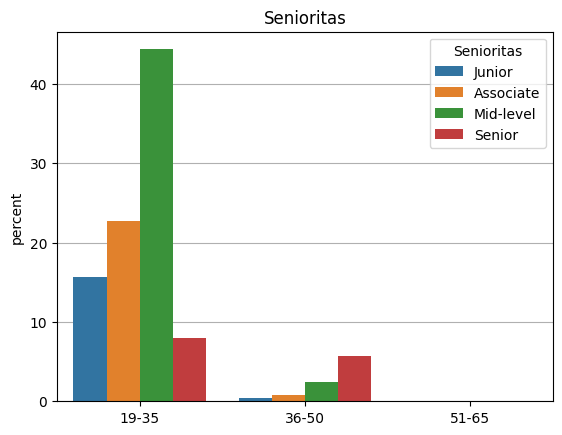

In [ ]:
# Visualisasi hubungan Usia terhadap Senioritas
sns.countplot(df, x = "Usia", hue = "Senioritas", stat = "percent")
plt.title("Senioritas")
plt.xlabel("")
plt.legend(["Junior", "Associate", "Mid-level", "Senior"], title = "Senioritas")
plt.xticks([0, 1, 2], ["19-35", "36-50", "51-65"])
plt.grid(visible = True, axis = "y")
plt.show()

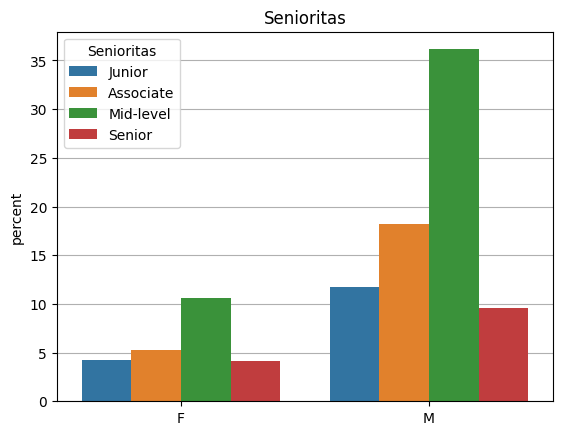

In [ ]:
# Visualisasi hubungan Jenis Kelamin terhadap Senioritas
sns.countplot(df, x = "Jenis Kelamin", hue = "Senioritas", stat = "percent")
plt.title("Senioritas")
plt.xlabel("")
plt.legend(["Junior", "Associate", "Mid-level", "Senior"], title = "Senioritas")
plt.xticks([0, 1], ["F", "M"])
plt.grid(visible = True, axis = "y")
plt.show()

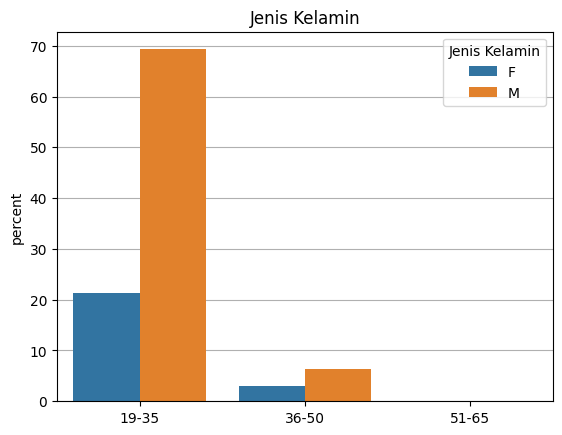

In [ ]:
# Visualisasi hubungan jenis kelamin dan usia
sns.countplot(df, x = "Usia", hue = "Jenis Kelamin", stat = "percent")
plt.title("Jenis Kelamin")
plt.xlabel("")
plt.legend(["F", "M"], title = "Jenis Kelamin")
plt.xticks([0, 1, 2], ["19-35", "36-50", "51-65"])
plt.grid(visible = True, axis = "y")
plt.show()

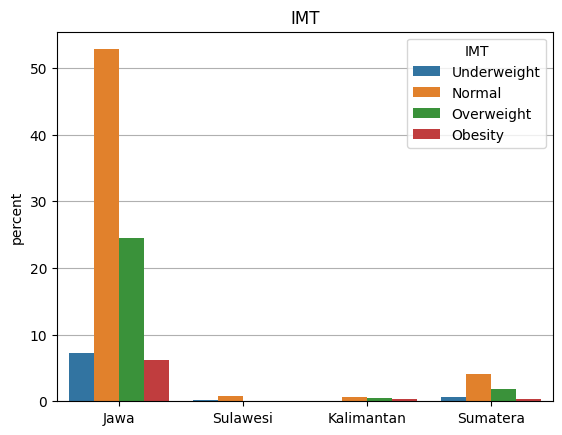

In [ ]:
# Visualisasi hubungan Tempat lahir terhadap IMT
sns.countplot(df, x = "Tempat lahir", hue = "IMT", stat = "percent")
plt.title("IMT")
plt.xlabel("")
plt.legend(["Underweight", "Normal", "Overweight", "Obesity"], title = "IMT")
plt.xticks([0, 1, 2, 3], ["Jawa", "Sulawesi", "Kalimantan", "Sumatera"])
plt.grid(visible = True, axis = "y")
plt.show()

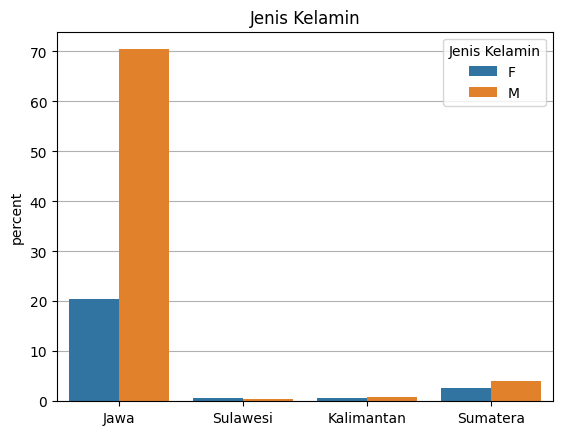

In [ ]:
# Visualisasi hubungan Tempat lahir terhadap Jenis Kelamin
sns.countplot(df, x = "Tempat lahir", hue = "Jenis Kelamin", stat = "percent")
plt.title("Jenis Kelamin")
plt.xlabel("")
plt.legend(["F", "M"], title = "Jenis Kelamin")
plt.xticks([0, 1, 2, 3], ["Jawa", "Sulawesi", "Kalimantan", "Sumatera"])
plt.grid(visible = True, axis = "y")
plt.show()

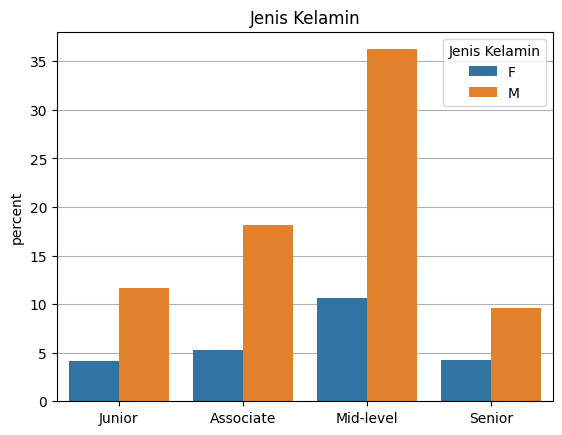

In [ ]:
# Visualisasi hubungan Senioritas terhadap Jenis Kelamin
sns.countplot(df, x = "Senioritas", hue = "Jenis Kelamin", stat = "percent")
plt.title("Jenis Kelamin")
plt.xlabel("")
plt.legend(["F", "M"], title = "Jenis Kelamin")
plt.xticks([0, 1, 2, 3], ["Junior", "Associate", "Mid-level", "Senior"])
plt.grid(visible = True, axis = "y")
plt.show()

In [ ]:
# Melakukan uji chi squared antar variabel kategorik dan target "CT" dengan tempat lahir
chi2_stats = []
p_values = []
for i in ["Jenis Kelamin", "Usia", "IMT", "Senioritas", "Sumatera", "Kalimantan", "Sulawesi"]:
  chi2_stat, p_value = chi2(X = df[[i]], y = df["CT"])
  chi2_stats.append(chi2_stat[0])
  p_values.append(p_value[0])
result = pd.DataFrame()
result["Variabel"] = ["Jenis Kelamin", "Usia", "IMT", "Senioritas", "Sumatera", "Kalimantan", "Sulawesi"]
result["Chi2Stat"] = chi2_stats
result["P_value"] = p_values
result.sort_values(by = "P_value", ascending = True).reset_index(drop = True)

Variabel   Chi2Stat       P_value
0           Usia  29.056909  7.028299e-08
1     Senioritas   9.287824  2.306820e-03
2       Sumatera   5.648382  1.747148e-02
3            IMT   4.675144  3.060214e-02
4  Jenis Kelamin   2.231221  1.352469e-01
5     Kalimantan   1.627959  2.019856e-01
6       Sulawesi   0.658162  4.172097e-01

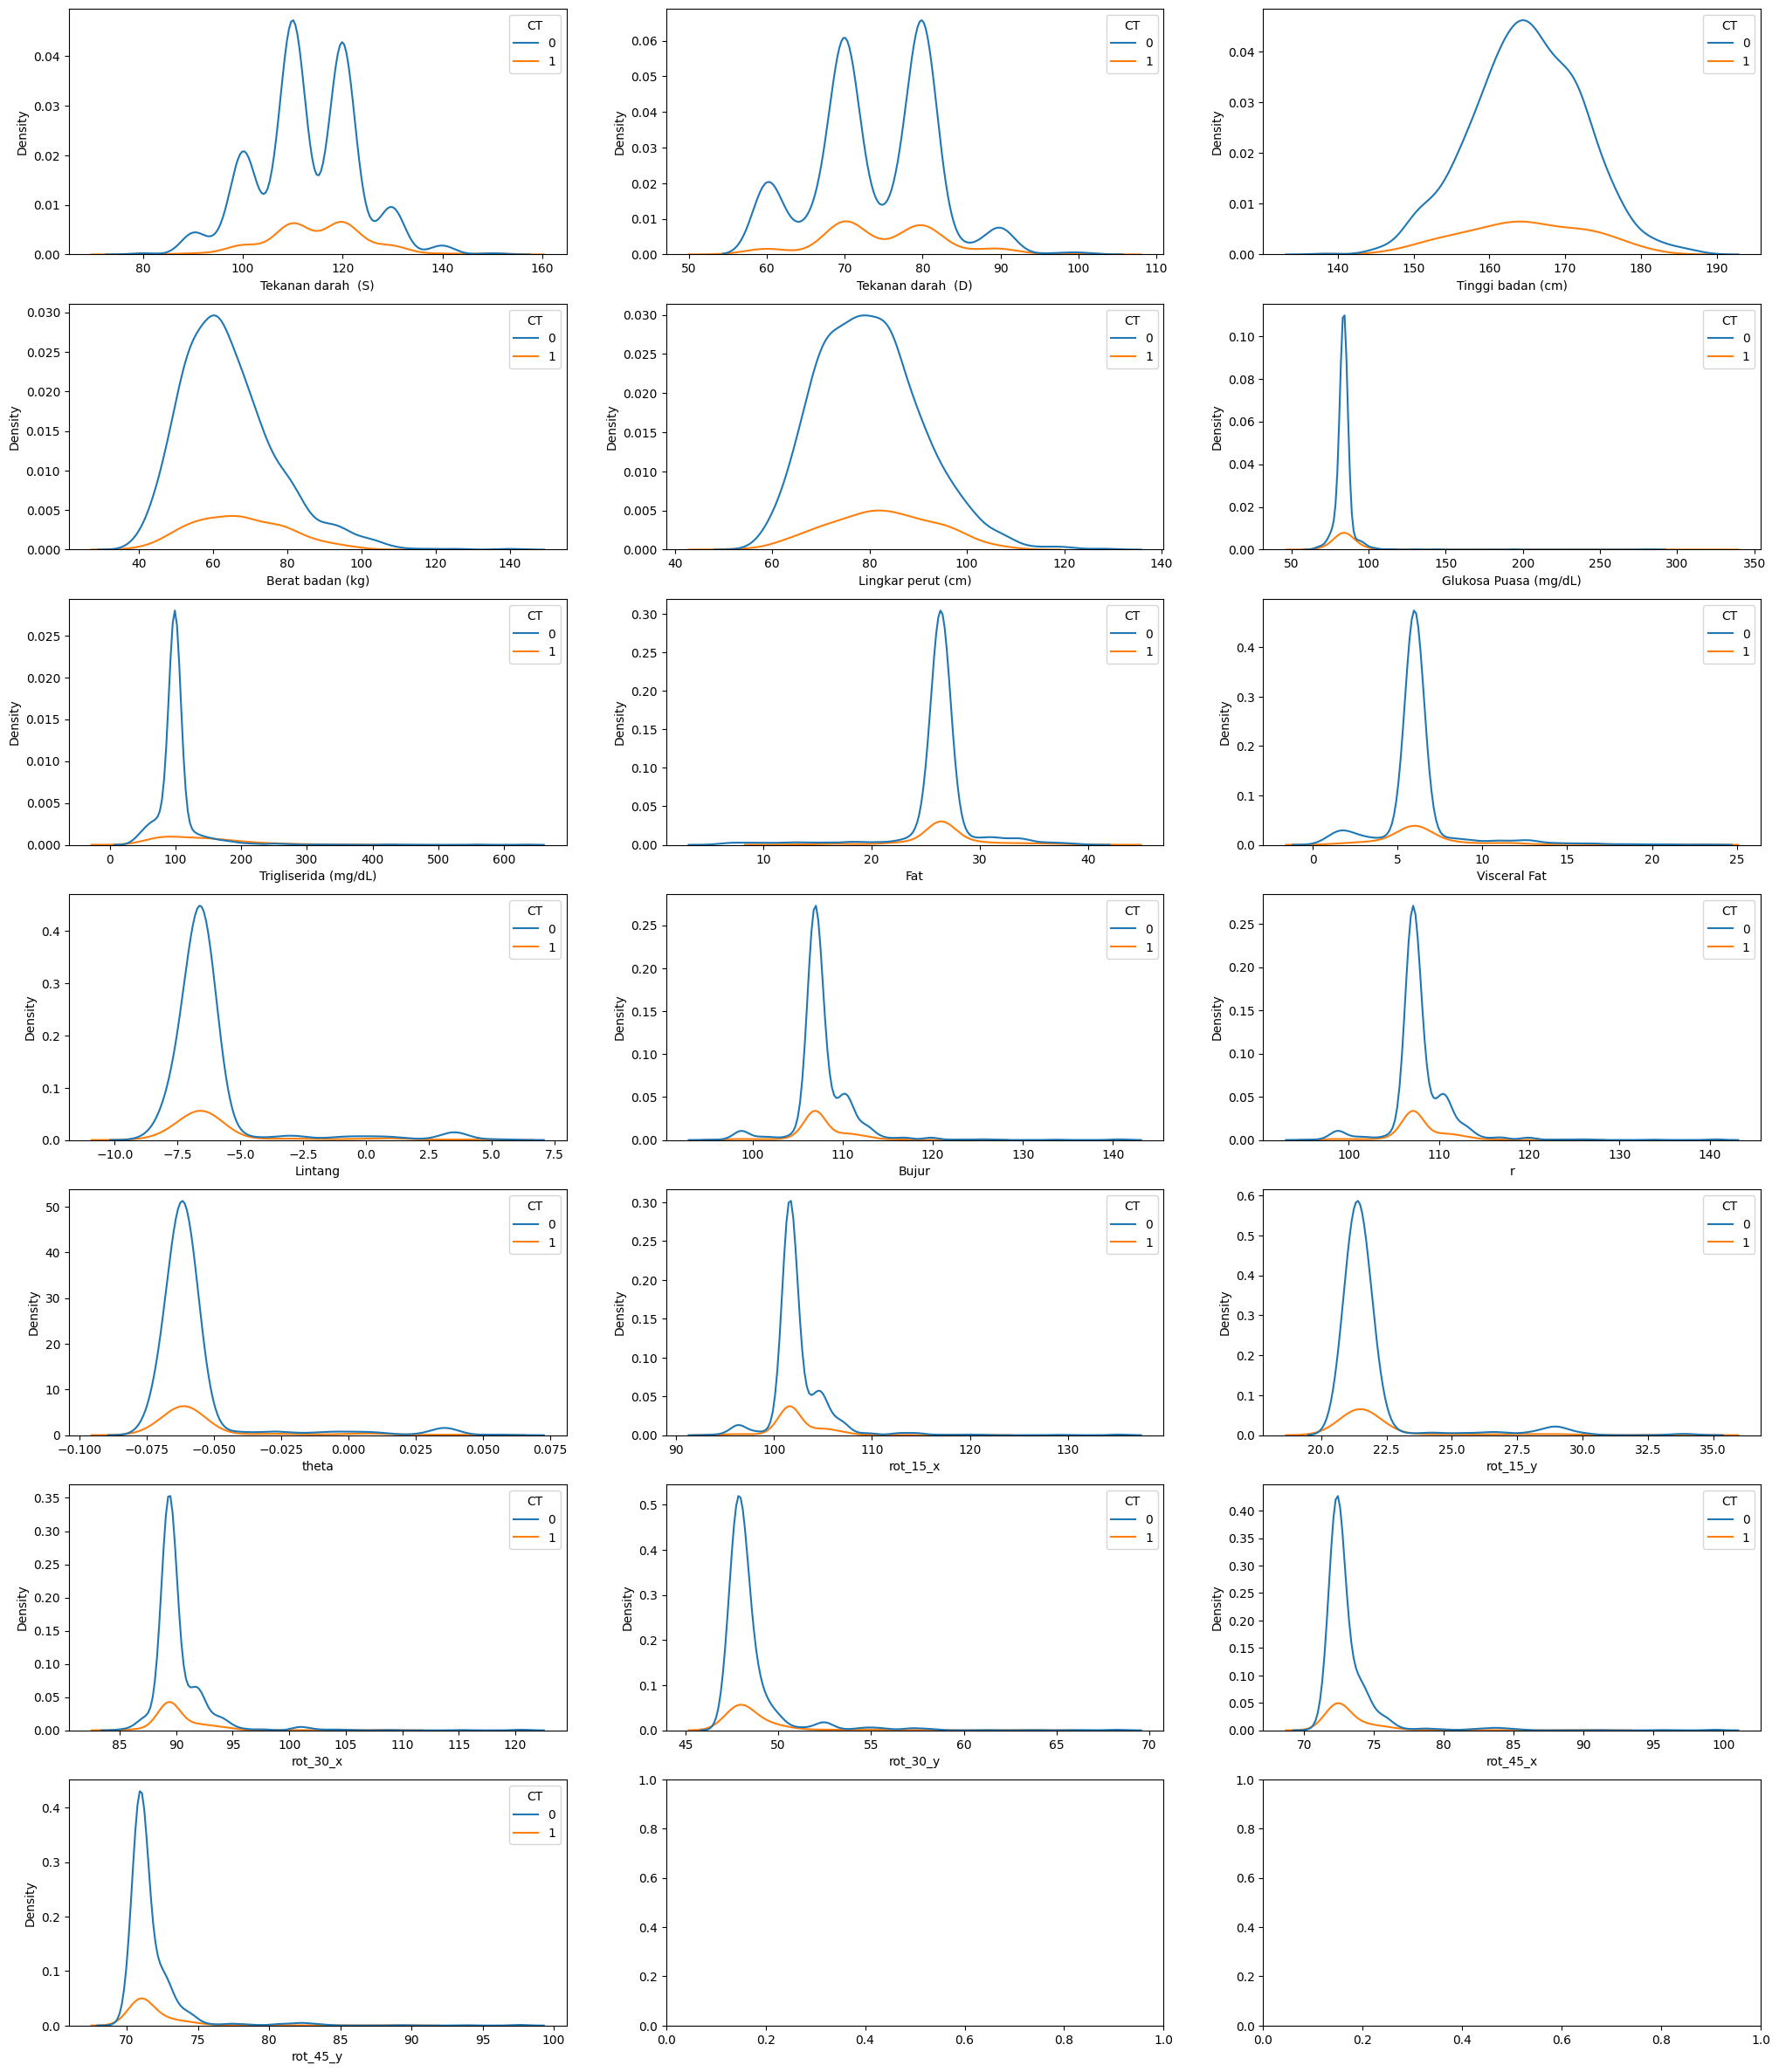

In [ ]:
# Melakukan visualisasi variabel numerik
numeric = ['Tekanan darah  (S)', 'Tekanan darah  (D)', 'Tinggi badan (cm)',
          'Berat badan (kg)', 'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)',
          'Trigliserida (mg/dL)', 'Fat', 'Visceral Fat', 'Lintang', 'Bujur',
           'r', 'theta', 'rot_15_x', 'rot_15_y', 'rot_30_x',
           'rot_30_y', 'rot_45_x', 'rot_45_y']

fig, ax = plt.subplots(7, 3, figsize = (25, 30))
ax = ax.flatten()

for i, j in enumerate(numeric):
  sns.kdeplot(x = j, hue = "CT", data = df, ax = ax[i])

Text(0.5, 1.0, 'Distribusi Lingkar Perut per IMT')

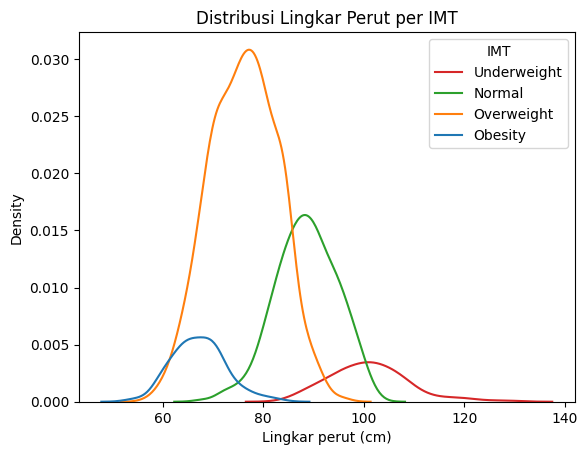

In [ ]:
# Visualisasi distribusi lingkar perut per IMT
sns.kdeplot(x = "Lingkar perut (cm)", hue = "IMT", data = df)
plt.legend(["Underweight", "Normal", "Overweight", "Obesity"], title = "IMT")
plt.title("Distribusi Lingkar Perut per IMT")

Text(0.5, 1.0, 'Distribusi Lingkar Perut per Tempat Lahir')

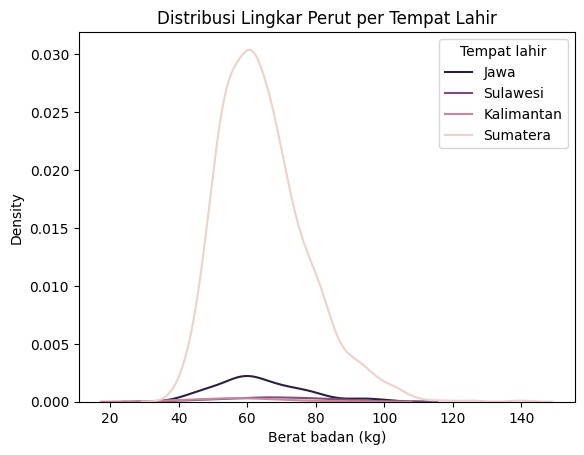

In [ ]:
# Visualisasi distribusi lingkar perut per IMT
sns.kdeplot(x = "Berat badan (kg)", hue = "Tempat lahir", data = df)
plt.legend(["Jawa", "Sulawesi", "Kalimantan", "Sumatera"], title = "Tempat lahir")
plt.title("Distribusi Lingkar Perut per Tempat Lahir")

Text(0.5, 1.0, 'Distribusi Berat Badan per IMT')

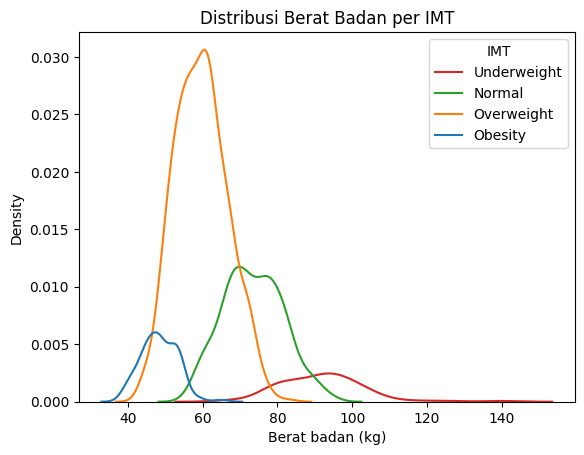

In [ ]:
# Visualisasi distribusi berat badan per IMT
sns.kdeplot(x = "Berat badan (kg)", hue = "IMT", data = df)
plt.legend(["Underweight", "Normal", "Overweight", "Obesity"], title = "IMT")
plt.title("Distribusi Berat Badan per IMT")

In [ ]:
# Melakukan uji kolmogorov-smirnov antar variabel numerik dan target "CT"
numeric = ['Tekanan darah  (S)', 'Tekanan darah  (D)', 'Tinggi badan (cm)',
          'Berat badan (kg)', 'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)',
          'Trigliserida (mg/dL)', 'Fat', 'Visceral Fat', 'Lintang', 'Bujur',
           'r', 'theta', 'rot_15_x', 'rot_15_y', 'rot_30_x',
           'rot_30_y', 'rot_45_x', 'rot_45_y']
ks_stats = []
p_values = []
for i in numeric:
  X1 = df[df["CT"] == 0][i]
  X2 = df[df["CT"] == 1][i]
  ks_stat, p_value = ks_2samp(X1, X2)
  ks_stats.append(ks_stat)
  p_values.append(p_value)
result = pd.DataFrame()
result["Variabel"] = numeric
result["KSStat"] = ks_stats
result["P_value"] = p_values
result.sort_values(by = "P_value", ascending = True).reset_index(drop = True)

Variabel    KSStat       P_value
0    Trigliserida (mg/dL)  0.515187  1.032772e-41
1                rot_15_y  0.192858  5.731980e-06
2        Berat badan (kg)  0.154439  5.572945e-04
3                 Lintang  0.137663  2.979278e-03
4                   theta  0.137018  3.165382e-03
5      Lingkar perut (cm)  0.130913  5.537441e-03
6                     Fat  0.130530  5.728050e-03
7   Glukosa Puasa (mg/dL)  0.130121  5.940924e-03
8                rot_30_y  0.126107  8.448712e-03
9            Visceral Fat  0.125951  8.558203e-03
10     Tekanan darah  (D)  0.112789  2.505768e-02
11     Tekanan darah  (S)  0.104165  4.750047e-02
12               rot_45_x  0.083723  1.764841e-01
13               rot_45_y  0.083723  1.764841e-01
14               rot_30_x  0.071214  3.412243e-01
15               rot_15_x  0.069452  3.709426e-01
16      Tinggi badan (cm)  0.067517  4.054111e-01
17                      r  0.055355  6.561059e-01
18                  Bujur  0.055119  6.612795e-01

In [ ]:
result.sort_values(by = "P_value", ascending = True).reset_index(drop = True).iloc[:12, 0].values

array(['Trigliserida (mg/dL)', 'rot_15_y', 'Berat badan (kg)', 'Lintang',
       'theta', 'Lingkar perut (cm)', 'Fat', 'Glukosa Puasa (mg/dL)',
       'rot_30_y', 'Visceral Fat', 'Tekanan darah  (D)',
       'Tekanan darah  (S)'], dtype=object)

In [ ]:
# Melakukan pengecekan korelasi pearson antar variabel numerik
df[numeric].corr()

Tekanan darah  (S)  Tekanan darah  (D)  \
Tekanan darah  (S)               1.000000            0.777812   
Tekanan darah  (D)               0.777812            1.000000   
Tinggi badan (cm)                0.117712            0.108859   
Berat badan (kg)                 0.210907            0.236129   
Lingkar perut (cm)               0.160305            0.183578   
Glukosa Puasa (mg/dL)            0.044184            0.035256   
Trigliserida (mg/dL)             0.073002            0.060196   
Fat                              0.068022            0.057557   
Visceral Fat                     0.213759            0.198688   
Lintang                          0.008625            0.022833   
Bujur                           -0.058277           -0.074973   
r                               -0.058189           -0.074907   
theta                            0.005519            0.020186   
rot_15_x                        -0.059821           -0.074843   
rot_15_y                        -0.017016           -0.009255   
rot_30_x                        -0.059381           -0.071725   
rot_30_y                        -0.041191           -0.042008   
rot_45_x                        -0.054932           -0.063005   
rot_45_y                        -0.054394           -0.062095   

                       Tinggi badan (cm)  Berat badan (kg)  \
Tekanan darah  (S)              0.117712          0.210907   
Tekanan darah  (D)              0.108859          0.236129   
Tinggi badan (cm)               1.000000          0.504650   
Berat badan (kg)                0.504650          1.000000   
Lingkar perut (cm)              0.286745          0.865361   
Glukosa Puasa (mg/dL)           0.051655          0.126748   
Trigliserida (mg/dL)            0.060513          0.225218   
Fat                            -0.258876          0.129097   
Visceral Fat                    0.087222          0.433049   
Lintang                        -0.030246         -0.011615   
Bujur                          -0.025884         -0.020759   
r                              -0.025110         -0.020494   
theta                          -0.031564         -0.014862   
rot_15_x                       -0.032716         -0.023959   
rot_15_y                       -0.044240         -0.021872   
rot_30_x                       -0.039927         -0.026994   
rot_30_y                       -0.050183         -0.028417   
rot_45_x                       -0.046647         -0.029157   
rot_45_y                       -0.047040         -0.029238   

                       Lingkar perut (cm)  Glukosa Puasa (mg/dL)  \
Tekanan darah  (S)               0.160305               0.044184   
Tekanan darah  (D)               0.183578               0.035256   
Tinggi badan (cm)                0.286745               0.051655   
Berat badan (kg)                 0.865361               0.126748   
Lingkar perut (cm)               1.000000               0.154823   
Glukosa Puasa (mg/dL)            0.154823               1.000000   
Trigliserida (mg/dL)             0.263642               0.103235   
Fat                              0.171367               0.015807   
Visceral Fat                     0.386982               0.014330   
Lintang                         -0.004153               0.017647   
Bujur                           -0.004604              -0.020640   
r                               -0.004575              -0.020827   
theta                           -0.007773               0.017748   
rot_15_x                        -0.005598              -0.018555   
rot_15_y                        -0.006549               0.009682   
rot_30_x                        -0.006614              -0.015227   
rot_30_y                        -0.007778              -0.000933   
rot_45_x                        -0.007496              -0.009927   
rot_45_y                        -0.007544              -0.009466   

                       Trigliserida (mg/dL)       Fat  Visceral Fat   Lintang  \
Tekanan darah  (S)                 0.07

Text(0.5, 1.0, 'Pengaruh Glukosa terhadap CT')

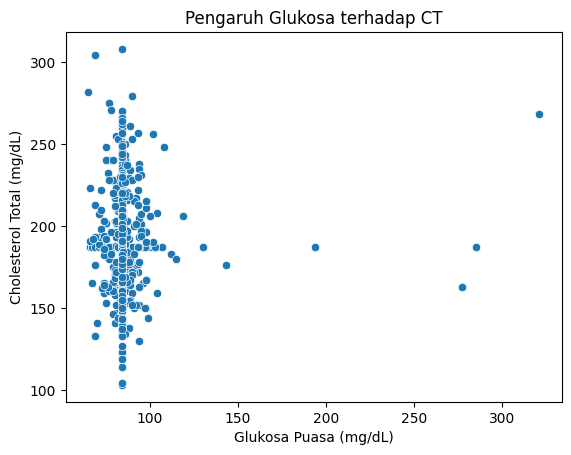

In [ ]:
# Visualisasi hubungan glukosa dengan CT
sns.scatterplot(x = "Glukosa Puasa (mg/dL)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Glukosa terhadap CT")

Text(0.5, 1.0, 'Pengaruh Visceral Fat terhadap CT')

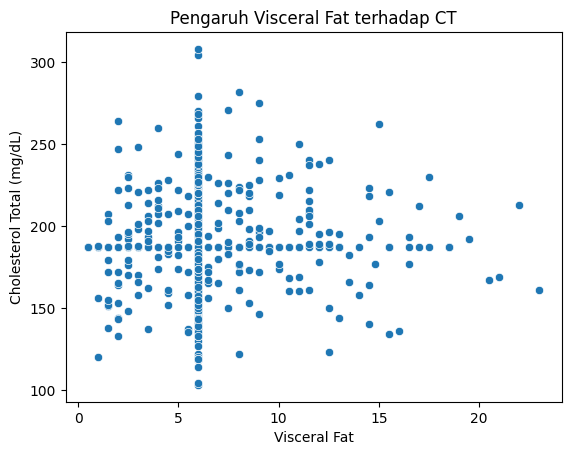

In [ ]:
# Visualisasi hubungan viseral fat dengan CT
sns.scatterplot(x = "Visceral Fat", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Visceral Fat terhadap CT")

Text(0.5, 1.0, 'Pengaruh Trigliserida terhadap CT')

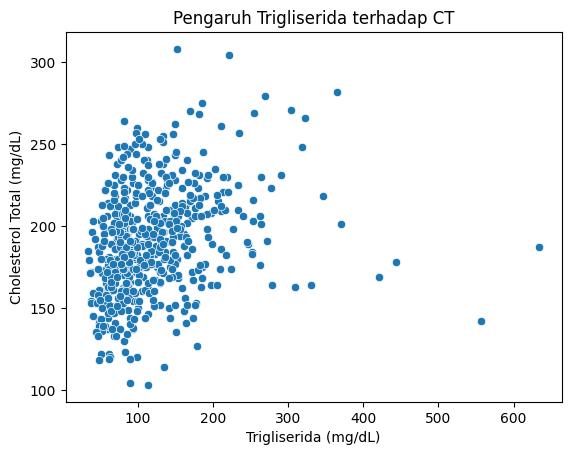

In [ ]:
# Visualisasi hubungan trigliserida dengan CT
sns.scatterplot(x = "Trigliserida (mg/dL)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Trigliserida terhadap CT")

Text(0.5, 1.0, 'Pengaruh Fat terhadap CT')

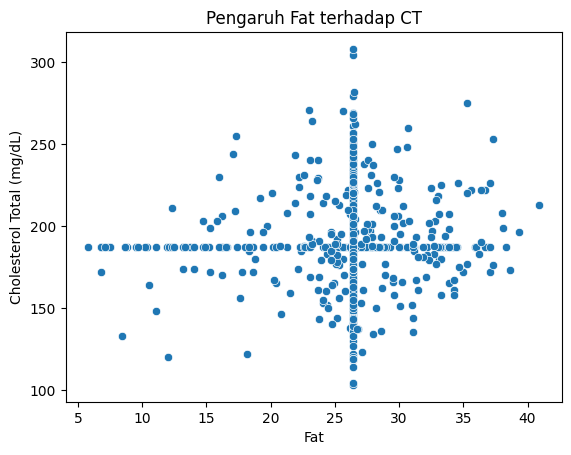

In [ ]:
# Visualisasi hubungan lingkar perut dengan CT
# Mungkin akan lebih baik jika dibuang (?)
sns.scatterplot(x = "Fat", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Fat terhadap CT")

<Axes: title={'center': 'Pengaruh Lingkar Perut terhadap Visceral Fat'}, xlabel='Lingkar perut (cm)', ylabel='Visceral Fat'>

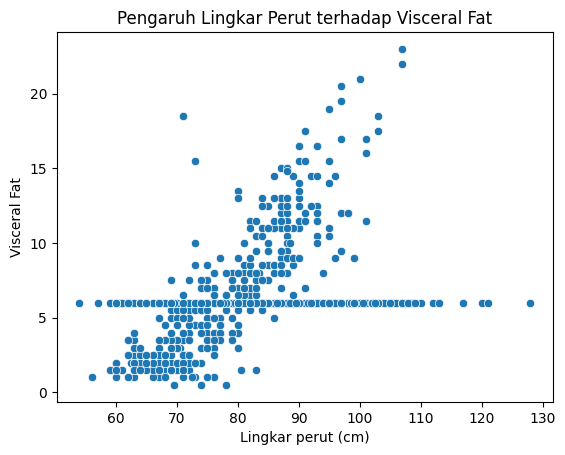

In [ ]:
plt.title("Pengaruh Lingkar Perut terhadap Visceral Fat")
sns.scatterplot(x = "Lingkar perut (cm)", y = "Visceral Fat", data = df)

Text(0.5, 1.0, 'Pengaruh Masa Kerja terhadap CT')

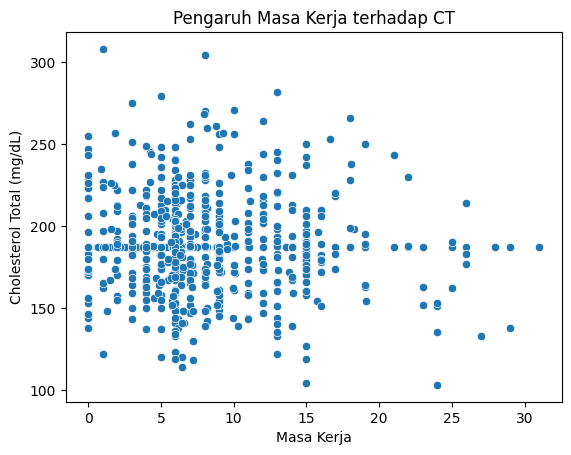

In [ ]:
# Visualisasi Massa Kerja dengan CT
sns.scatterplot(x = "Masa Kerja", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Masa Kerja terhadap CT")

Text(0.5, 1.0, 'Pengaruh Tinggi terhadap CT')

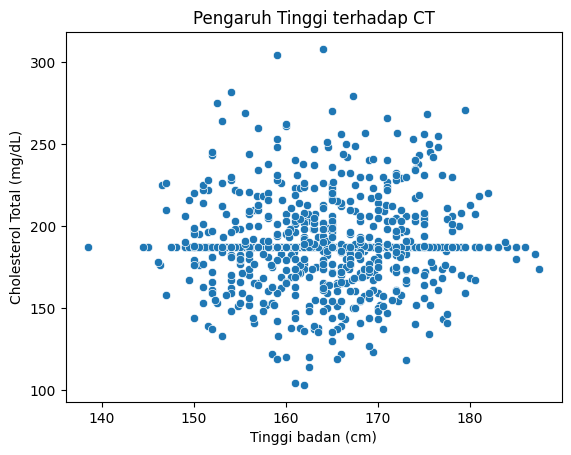

In [ ]:
# Visualisasi Tinggi dengan CT
sns.scatterplot(x = "Tinggi badan (cm)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Tinggi terhadap CT")

Text(0.5, 1.0, 'Pengaruh Usia terhadap CT')

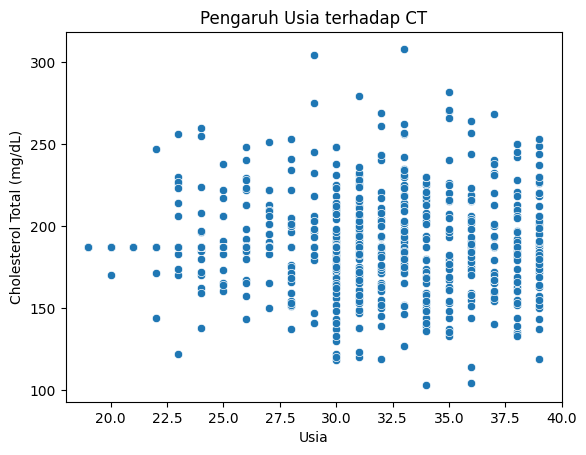

In [ ]:
# Visualisasi Usia dengan CT
sns.scatterplot(x = "Usia", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Usia terhadap CT")

Text(0.5, 1.0, 'Pengaruh Berat badan (kg) terhadap CT')

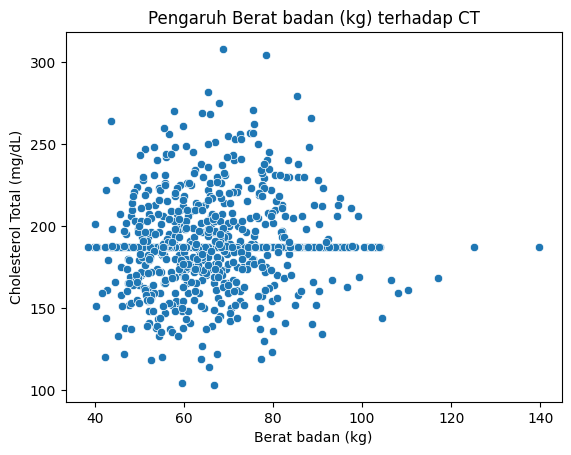

In [ ]:
# Visualisasi hubungan Berat Badan (kg) dengan CT
sns.scatterplot(x = "Berat badan (kg)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Berat badan (kg) terhadap CT")

Text(0.5, 1.0, 'Pengaruh Tekanan darah (S) terhadap CT')

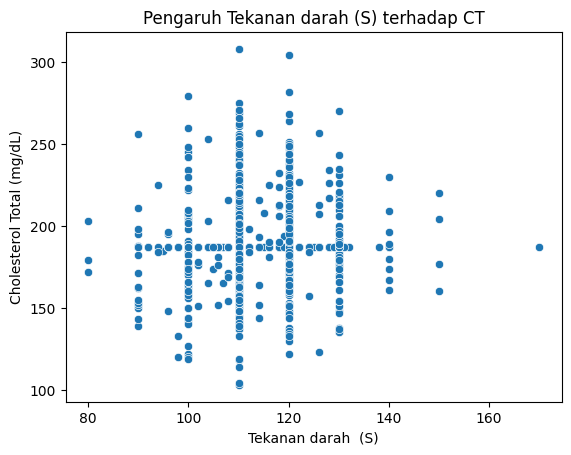

In [ ]:
# Visualisasi hubungan Tekanan darah (S) dengan CT
# Mungkin akan lebih baik jika dibuat kategorik
sns.scatterplot(x = "Tekanan darah  (S)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Tekanan darah (S) terhadap CT")

Text(0.5, 1.0, 'Pengaruh IMT terhadap CT')

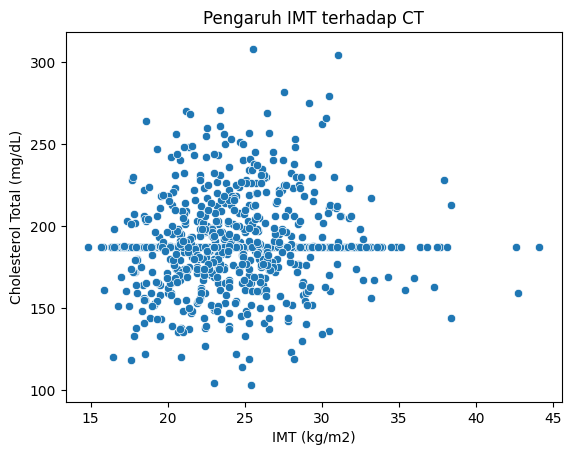

In [ ]:
# Visualisasi hubungan IMT` dengan CT
sns.scatterplot(x = "IMT (kg/m2)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh IMT terhadap CT")

Text(0.5, 1.0, 'Pengaruh Lingkar Perut terhadap CT')

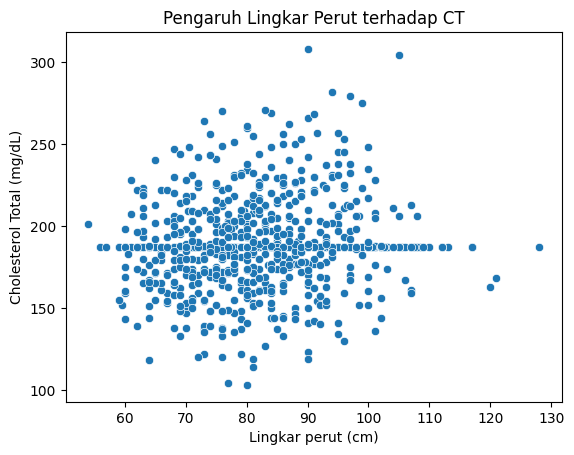

In [ ]:
# Visualisasi hubungan lingkar perut dengan CT
sns.scatterplot(x = "Lingkar perut (cm)", y = "Cholesterol Total (mg/dL)", data = df)
plt.title("Pengaruh Lingkar Perut terhadap CT")

Text(0.5, 1.0, 'Pengaruh Visceral Fat terhadap Trigliserida')

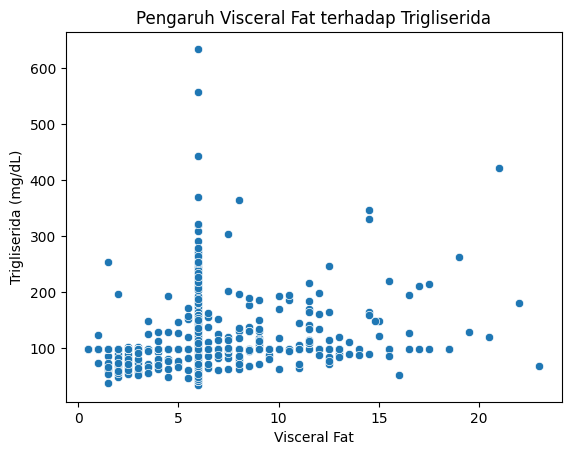

In [ ]:
# Visualisasi hubungan Fat dengan Visceral Fat
sns.scatterplot(x = "Visceral Fat", y = "Trigliserida (mg/dL)", data = df)
plt.title("Pengaruh Visceral Fat terhadap Trigliserida")

# Modelling and Evaluation

In [ ]:
# Memilih variabel X dan y berdasarkan hasil uji
cols = ["Jenis Kelamin", "Sulawesi", "Kalimantan", "Tempat lahir"]
X = df.drop(cols, axis = 1).copy()
y = X.pop("CT")

# Melakukan perhitungan VIF
vif = calc_vif(X).sort_values(by = "VIF", ascending = True).reset_index(drop = True)
X = X.drop(vif.query("VIF > 15")["variables"], axis = 1)

In [24]:
# Melihat hasil VIF
vif

variables           VIF
0                    Usia  1.270533e+00
1                Sumatera  2.658443e+00
2              Senioritas  4.849002e+00
3    Trigliserida (mg/dL)  7.703974e+00
4            Visceral Fat  1.114824e+01
5                     IMT  2.369296e+01
6   Glukosa Puasa (mg/dL)  5.605032e+01
7                     Fat  6.352099e+01
8      Tekanan darah  (D)  2.400015e+02
9        Berat badan (kg)  2.549307e+02
10     Lingkar perut (cm)  2.648361e+02
11     Tekanan darah  (S)  3.271994e+02
12      Tinggi badan (cm)  1.063977e+03
13                  theta  4.163646e+03
14                      r  2.989164e+06
15                Lintang           inf
16                  Bujur           inf
17               rot_15_x           inf
18               rot_15_y           inf
19               rot_30_x           inf
20               rot_30_y           inf
21               rot_45_x           inf
22               rot_45_y           inf

In [25]:
# Melakukan pengecekan X
X

Usia  Trigliserida (mg/dL)  Visceral Fat Senioritas  Sumatera
0       0                  99.0           6.0          0         0
1       0                 147.0           6.0          2         0
2       0                  99.0          12.5          0         0
3       0                 185.0          10.5          1         0
4       0                  99.0           6.0          2         0
...   ...                   ...           ...        ...       ...
1328    1                 114.0           6.0          3         1
1329    1                 120.0          20.5          0         1
1330    1                 263.0          19.0          3         0
1331    1                 108.0           6.0          2         0
1332    1                 150.0           6.0          2         1

[1333 rows x 5 columns]

In [ ]:
# Membuat berbagai model untuk menguji kecocokan dengan features tertentu walaupun tidak semua kombinasi
cols = [["Usia"], ["Trigliserida (mg/dL)"], ["Visceral Fat"], ["Sumatera"], ["Senioritas"],
        ["Usia", "Trigliserida (mg/dL)"], ["Usia", "Visceral Fat"], ["Usia", "Sumatera"], ["Usia", "Senioritas"],
        ["Usia", "Trigliserida (mg/dL)", "Visceral Fat"], ["Usia", "Trigliserida (mg/dL)", "Sumatera"],
        ["Usia", "Trigliserida (mg/dL)", "Senioritas"], ["Usia", "Trigliserida (mg/dL)", "Visceral Fat", "Sumatera"],
        ["Usia", "Trigliserida (mg/dL)", "Visceral Fat", "Senioritas"], ["Usia", "Trigliserida (mg/dL)", "Visceral Fat", "Sumatera", "Senioritas"]]

result = calc_aic_bic(X, y, cols).sort_values(by = "AIC", ascending = True).reset_index(drop = True)
col = result["Variabel"][4]
X = X[col].copy()

In [13]:
# Melihat hasil uji kecocokan model
result

Variabel  Jumlah Parameter  \
0   [Usia, Trigliserida (mg/dL), Visceral Fat, Sum...                 6   
1            [Usia, Trigliserida (mg/dL), Senioritas]                 4   
2              [Usia, Trigliserida (mg/dL), Sumatera]                 4   
3   [Usia, Trigliserida (mg/dL), Visceral Fat, Sen...                 5   
4   [Usia, Trigliserida (mg/dL), Visceral Fat, Sum...                 5   
5                        [Usia, Trigliserida (mg/dL)]                 3   
6          [Usia, Trigliserida (mg/dL), Visceral Fat]                 4   
7                              [Trigliserida (mg/dL)]                 2   
8                                  [Usia, Senioritas]                 3   
9                                    [Usia, Sumatera]                 3   
10                                             [Usia]                 2   
11                               [Usia, Visceral Fat]                 3   
12                                       [Senioritas]                 2   
13                                         [Sumatera]                 2   
14                                     [Visceral Fat]                 2   

    Log-Likelihood         AIC         BIC  
0      -392.684805  797.369609  828.540733  
1      -395.975490  799.950980  820.731729  
2      -395.991279  799.982559  820.763308  
3      -395.861646  801.723292  827.699228  
4      -395.941703  801.883405  827.859342  
5      -398.449504  802.899007  818.484569  
6      -398.423341  804.846681  825.627430  
7      -404.776135  813.552270  823.942644  
8      -420.696034  847.392069  862.977631  
9      -422.903757  851.807513  867.393075  
10     -425.368935  854.737869  865.128244  
11     -424.395351  854.790703  870.376265  
12     -426.137030  856.274059  866.664434  
13     -434.005374  872.010748  882.401122  
14     -434.143023  872.286046  882.676420

In [ ]:
# Melakukan uji performa model
model1, report1 = uji_performa_model(X, y, 29)
model2, report2 = uji_performa_model(X[["Usia", "Trigliserida (mg/dL)"]], y, 29)

In [26]:
# Melakukan train test split
X = sm.add_constant(X)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 29)

In [27]:
# Melakukan logistic regression dengan statsmodels
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.396951
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     CT   No. Observations:                 1066
Model:                          Logit   Df Residuals:                     1060
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Apr 2024   Pseudo R-squ.:                 0.09213
Time:                        14:52:16   Log-Likelihood:                -423.15
converged:                       True   LL-Null:                       -466.09
Covariance Type:            nonrobust   LLR p-value:                 4.907e-17
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.3757      0.319    -10.597      0.000      -4.000      -2.751

In [28]:
preds = np.round(model.predict(X_valid))
print(classification_report(preds, y_valid))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95       261
         1.0       0.14      0.67      0.23         6

    accuracy                           0.90       267
   macro avg       0.56      0.79      0.59       267
weighted avg       0.97      0.90      0.93       267



<Axes: xlabel='0', ylabel='1'>

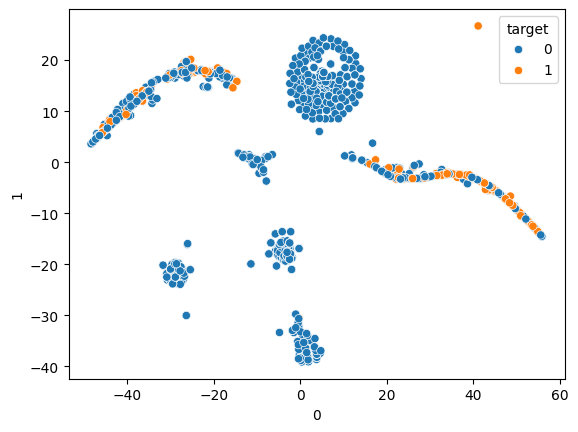

In [33]:
# Melakukan visualisasi TSNE
tsne = TSNE(n_components = 2)
X_tsne = pd.DataFrame(tsne.fit_transform(X))
X_tsne["target"] = y
sns.scatterplot(x = 0, y = 1, hue = "target", data = X_tsne)

<Axes: xlabel='0', ylabel='1'>

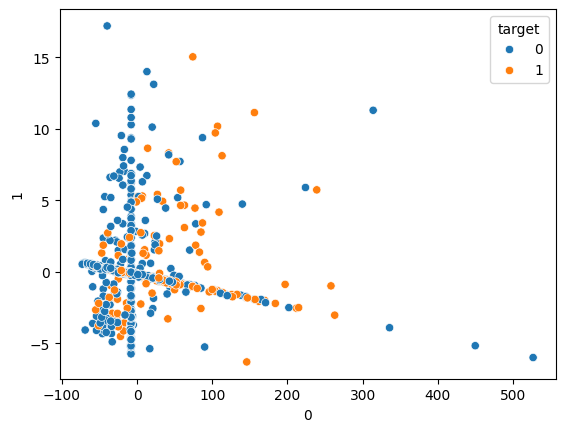

In [34]:
# Melakukan visualisasi PCA
tsne = PCA(n_components = 2)
X_tsne = pd.DataFrame(tsne.fit_transform(X))
X_tsne["target"] = y
sns.scatterplot(x = 0, y = 1, hue = "target", data = X_tsne)